In [1453]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from typing import Dict, List, Set
import numpy as np
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [1454]:
locations_synonyms: Dict[str, List[str]] = {
    "Warszawa": ["Warsaw", "Warszawa", "Katowice; Warszawa", "Warszawa (Centrum)", "Waraszawa"],
    "Kraków": ["Krakow", "Kraków"],
    "Wrocław": ["Wroclaw", "Wrocław"],
    "Poznań": ["Poznan", "Poznań", "Pozanań"],
    "Gdańsk": ["Gdansk", "Gdańsk"],
    "Szczecin": ["Szczecin", "szczecin"],
    "Łódź": ["Lodz", "Łódź"],
    "Rzeszów": ["Rzeszow", "Rzeszów"],
    "Katowice": ["Katowice", "Katowice; Warszawa"],
    "Kielce": ["Kielce"],
    "Opole": ["opole", "Opole"],
    "Sopot": ["Sopot"],
    "Olszytn": ["Olsztyn"],
    "Gdynia": ["Gdynia"],
}

location_encoder = LabelEncoder()
exp_encoder = LabelEncoder()
mode_encoder = LabelEncoder()

# read data from json file
df = pd.read_json("../data/offers.json")

def replace_synonyms(locations):
    for standard, synonyms in locations_synonyms.items():
        for i, loc in enumerate(locations):
            if loc in synonyms:
                locations[i] = standard
    return locations

df["locations"] = df["locations"].apply(replace_synonyms)
df = df.explode("locations")
df["location"] = df["locations"]

df["location_code"] = location_encoder.fit_transform(df["location"])

df["experience_code"] = exp_encoder.fit_transform(df["experience"])
df["operating_mode_code"] = mode_encoder.fit_transform(df["operating_mode"])
df = df.drop(columns=["locations", "operating_mode", "experience", "location"])

mlb = MultiLabelBinarizer()

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('technologies')),
                          columns=mlb.classes_,
                          index=df.index))

df.to_csv("../data/offers_normalized_locations.csv", index=False)    


## Usuwanie niepotrzebnych danych

Na wszelki wypadek usuwam niepotrzebne dane, które mogą być niepotrzebne w przyszłości.
<p style="color: red">W przypadku ofert pracy gdzie nie ma definiowanych widełek dla np. b2b nie będę ich próbował wyliczać, bo nie ma to sensu, ponieważ zarobki zależą od technologi i poziomu doświadczenia.</p> 


In [1455]:
offers = pd.read_csv("../data/offers_normalized_locations.csv")

offers = offers.drop_duplicates()
offers = offers.dropna()

rows_to_drop = offers[((offers['max_uop'] < 1000) & (offers["max_uop"] > 0)) | ((offers['max_b2b'] < 1000) & (offers["max_b2b"] > 0))].index
offers = offers.drop(rows_to_drop)

offers.columns = offers.columns.str.strip()

offers.to_csv("../data/jobs.csv", index=False)

## Zapis i naprawa danych z formatu JSON do CSV.

Na początku tworze sobie synonimy dla najpopularniejszych nazw miast, ponieważ w niektórych przypadkach, 
miasta mają w sobie literówki np. `Waraszawa` albo nie obsłużyłem wystarczająco dużo przypadków przy miastach.
Następnie naprawiamy sobie lokacje oraz technologie. W przypadku technologii nie naprawam ich ponieważ mam pewność że są poprawne przez to ze były w jednym miejscu na stronie oraz po przejrzeniu ich nie znalazłem błędów.

# Szybki look na dane

In [1456]:
data = pd.read_csv('../data/jobs.csv')
df = pd.DataFrame(data)
# title,min_b2b,max_b2b,min_uop,max_uop,experience,operating_mode,experience_code,operating_mode_code
display(df.head())

title  min_b2b  max_b2b  \
0  Senior Software Engineer - Full Stack (JavaScr...        0        0   
1           Senior Backend Node.js Engineer (remote)        0        0   
2           Senior Backend Node.js Engineer (remote)        0        0   
3           Senior Backend Node.js Engineer (remote)        0        0   
4           Senior Backend Node.js Engineer (remote)        0        0   

   min_uop  max_uop  location_code  experience_code  operating_mode_code  AWS  \
0    18000    28000             51                2                    0    1   
1    18360    25125             38                2                    2    0   
2    18360    25125             17                2                    2    0   
3    18360    25125             51                2                    2    0   
4    18360    25125             55                2                    2    0   

   Angular  ...  React  Ruby  SQL  Scala  Spring  Terraform  TypeScript  \
0        0  ...      1     0    0      0       0          1           1   
1        0  ...      1     0    0      0       0          0           1   
2        0  ...      1     0    0      0       0          0           1   
3        0  ...      1     0    0      0       0          0           1   
4        0  ...      1     0    0      0       0          0           1   

   Vue.js  Windows  android  
0       0        0        0  
1       0        0        0  
2       0        0        0  
3       0        0        0  
4       0        0        0  

[5 rows x 42 columns]

In [1457]:
print(len(df))

4574


# Średnie zarobki na b2b dla juniora

In [1458]:
df[(df["min_b2b"] > 0) & (df["max_b2b"] > 0)].iloc[:, :3].describe().round(2)


min_b2b   max_b2b
count   3890.00   3890.00
mean   19139.54  25577.15
std     6277.14   7459.57
min     2349.00   3916.00
25%    15000.00  20505.00
50%    19200.00  25225.00
75%    23499.00  30000.00
max    45000.00  60000.00

In [1459]:
df[(df["min_uop"] > 0) & (df["max_uop"] > 0)].iloc[:, 3:5].describe().round(2)

min_uop   max_uop
count   1853.00   1853.00
mean   16198.06  22594.73
std     5879.03   8306.24
min     4250.00   6000.00
25%    12000.00  17000.00
50%    15000.00  21000.00
75%    19100.00  26000.00
max    40000.00  80000.00

# Zarobki na kontrakcie B2B 

In [1460]:
exp_code = df["experience_code"].value_counts().index
exp_name = exp_encoder.inverse_transform(exp_code)

for name in exp_name:
    code = exp_encoder.transform([name])[0]
    print(f"Experience: {name}")
    print(df[(df["experience_code"] == code) & (df["min_b2b"] > 0) & (df["max_b2b"] > 0)].iloc[:, :3].describe().round(2))
        

Experience: Senior
        min_b2b   max_b2b
count   2298.00   2298.00
mean   22297.60  29136.52
std     5271.13   6605.39
min     7833.00  11749.00
25%    19000.00  25000.00
50%    22000.00  28500.00
75%    25200.00  32000.00
max    45000.00  60000.00
Experience: Mid
        min_b2b   max_b2b
count   1491.00   1491.00
mean   15055.68  20995.32
std     4317.57   4951.93
min     2349.00   3916.00
25%    12000.00  18000.00
50%    15000.00  21000.00
75%    17000.00  25000.00
max    30000.00  37000.00
Experience: Junior
        min_b2b   max_b2b
count    101.00    101.00
mean    7573.17  12231.19
std     1848.20   3524.61
min     4400.00   6000.00
25%     6306.00  10000.00
50%     7833.00  11000.00
75%     8000.00  14000.00
max    14000.00  22000.00


In [1461]:
exp_code = df["experience_code"].value_counts().index
exp_name = exp_encoder.inverse_transform(exp_code)

for name in exp_name:
    code = exp_encoder.transform([name])[0]
    print(f"Experience: {name}")
    print(df[(df["experience_code"] == code) & (df["min_uop"] > 0) & (df["max_uop"] > 0)].iloc[:, 3:5].describe().round(2))
        

Experience: Senior
        min_uop   max_uop
count   1114.00   1114.00
mean   18930.61  25848.46
std     5665.84   8563.28
min     8000.00  11000.00
25%    15000.00  20000.00
50%    18300.00  24500.00
75%    22000.00  30000.00
max    40000.00  80000.00
Experience: Mid
        min_uop   max_uop
count    681.00    681.00
mean   12378.99  18041.77
std     2888.90   4440.94
min     5000.00   7000.00
25%    10000.00  15000.00
50%    13000.00  17000.00
75%    14000.00  20750.00
max    25000.00  30000.00
Experience: Junior
        min_uop   max_uop
count     58.00     58.00
mean    8555.40  13558.71
std     4120.82   6074.08
min     4250.00   6000.00
25%     5125.00   8250.00
50%     8000.00  11500.00
75%     9000.00  20125.00
max    16443.00  28000.00


# Tworzymy histogramy

Proponuje następujące rozkłady:
- typu pracy
- doświadczenia
- zarobków
- technologii
- lokalizacji


Zacznijmy od napisania funkcji która będzie tworzyć histogramy dla każdej z tych kategorii.

In [1462]:
import pandas as pd
import matplotlib.pyplot as plt

def get_histogram(data, column_name, title, encoder, label_x="", label_y="", is_specified=False, exp=None):
    if is_specified:
        exp_code = exp_encoder.transform([exp])[0]
        print(f"Experience: {exp_code}")
        data = data[data["experience_code"] == exp_code]
    # Zliczanie unikalnych wartości w kolumnie
    value_counts = data[column_name].value_counts().head(12)
    
    # Dekodowanie kodów na nazwy
    location_names = encoder.inverse_transform(value_counts.index)
    value_counts.index = location_names
    print(value_counts)
    
    # Tworzenie wykresu kołowego
    plt.figure(figsize=(8, 8))
    value_counts.plot(kind='pie', autopct='%1.1f%%')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"plots/rozkłady/{title.lower().replace(" ", "_")}.png")
    plt.show()



In [1463]:
def compute_amount_offers_for(exp):
    exp_code = exp_encoder.transform([exp])[0]
    offers_amount = df['experience_code'].value_counts()[exp_code]
    print(f"Liczba ofert pracy dla {exp}:", offers_amount)
    return offers_amount
    
mid_offers = compute_amount_offers_for("Mid")
senior_offers  = compute_amount_offers_for("Senior")
junior_offers =  compute_amount_offers_for("Junior")

assert mid_offers + senior_offers + junior_offers == len(df)

Liczba ofert pracy dla Mid: 1766
Liczba ofert pracy dla Senior: 2669
Liczba ofert pracy dla Junior: 139


## Histogram typu pracy

Remote    3818
Hybrid     635
Office     121
Name: count, dtype: int64


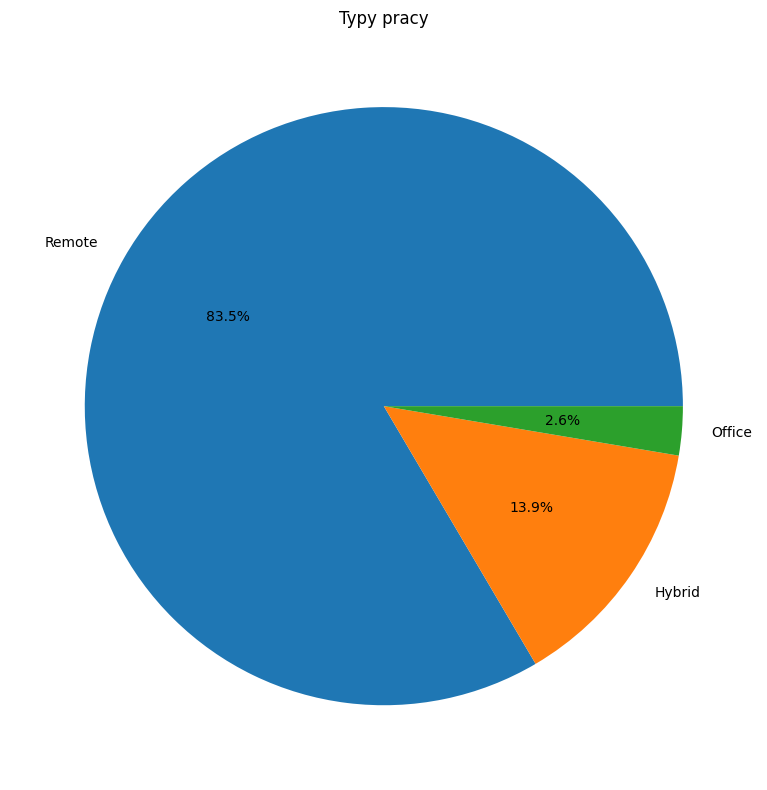

In [1464]:
get_histogram(df, 'operating_mode_code', 'Typy pracy', encoder=mode_encoder)

## Histogram doświadczenia

Senior    2669
Mid       1766
Junior     139
Name: count, dtype: int64


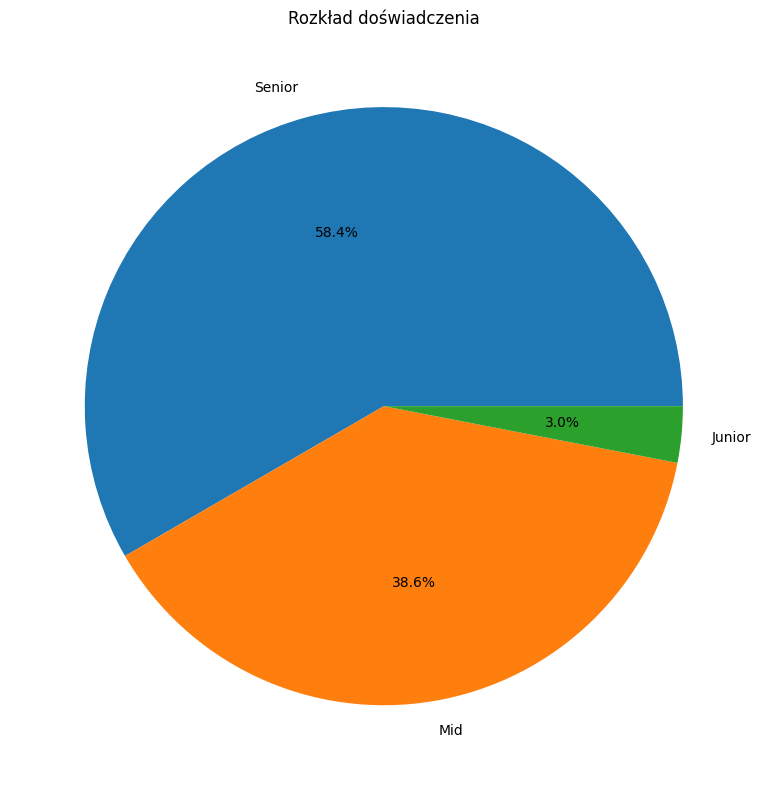

In [1465]:
get_histogram(df, 'experience_code', title="Rozkład doświadczenia", label_x="", label_y="", encoder=exp_encoder)

# Rozkład zarobków na B2B

In [1466]:
def salary_distribution(data, exp, encoder=exp_encoder, color='skyblue'):
    exp_code = encoder.transform([exp])[0]
    df_filtered_b2b = data[(data["min_b2b"] > 0) & (data["max_b2b"] > 0) & (data["experience_code"] == exp_code)].copy()

    print(f"Rozkład wynagrodzeń dla {exp}, liczba ofert z b2b: {len(df_filtered_b2b)}")

    df_filtered_b2b['avg_b2b'] = df_filtered_b2b[["min_b2b", "max_b2b"]].mean(axis=1)

    plt.figure(figsize=(20, 6))  # Adjust the size to accommodate two plots

    plt.subplot(1, 2, 1) # layout 
    sns.kdeplot(df_filtered_b2b['avg_b2b'], color=color)
    plt.title(f"Rozkład zarobków {exp}a na B2B")
    plt.xlabel(f"Średnie wynagrodzenie {exp}a na B2B")
    plt.ylabel("Gęstość ofert")
    plt.grid(True)

    df_filtered_uop = data[(data["min_uop"] > 0) & (data["max_uop"] > 0) & (data["experience_code"] == exp_code)].copy()
    print(f"Rozkład wynagrodzeń dla {exp}, liczba ofert z uop: {len(df_filtered_uop)}")
    df_filtered_uop['avg_uop'] = df_filtered_uop[["min_uop", "max_uop"]].mean(axis=1)

    # drugi
    plt.subplot(1, 2, 2)
    sns.kdeplot(df_filtered_uop['avg_uop'], color=color)
    plt.title(f"Rozkład zarobków {exp}a na UOP")
    plt.ylabel("Gęstość ofert")
    plt.xlabel(f"Średnie wynagrodzenie {exp}a na UOP")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/rozkłady/pensje_dla_{exp.lower()}a.png")
    plt.show()


Rozkład wynagrodzeń dla Mid, liczba ofert z b2b: 1491
Rozkład wynagrodzeń dla Mid, liczba ofert z uop: 681


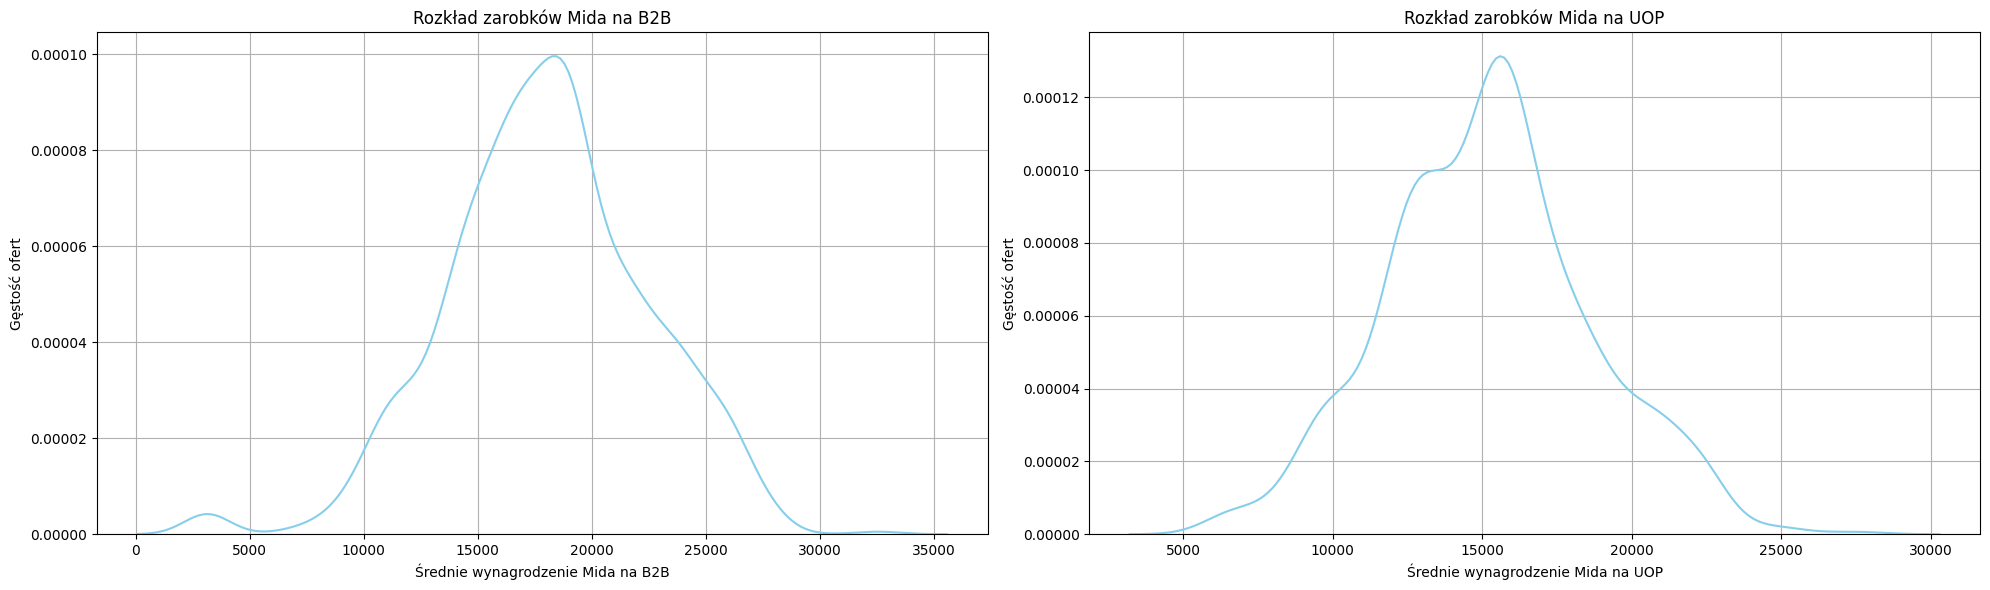

Rozkład wynagrodzeń dla Senior, liczba ofert z b2b: 2298
Rozkład wynagrodzeń dla Senior, liczba ofert z uop: 1114


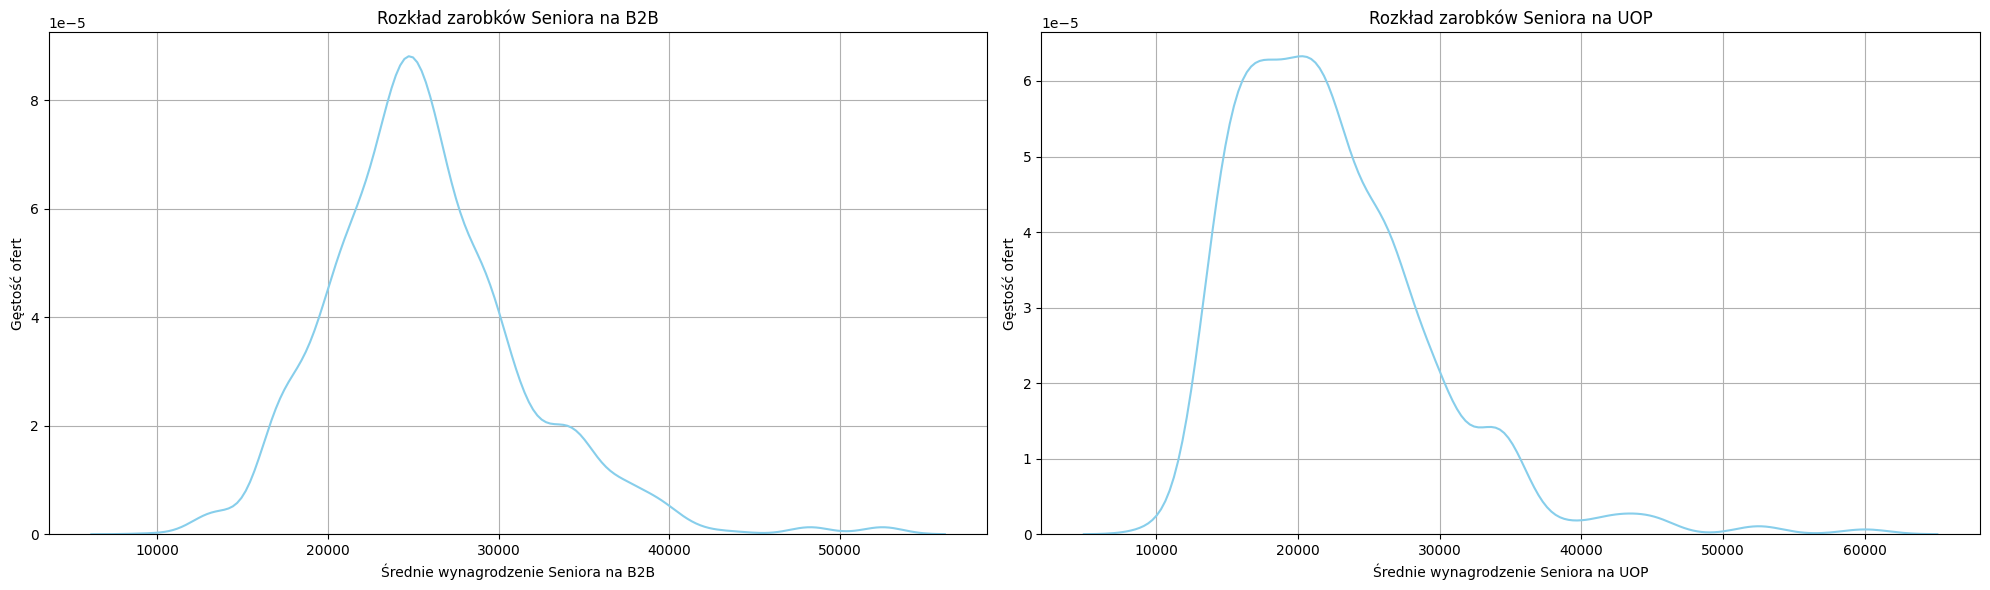

Rozkład wynagrodzeń dla Junior, liczba ofert z b2b: 101
Rozkład wynagrodzeń dla Junior, liczba ofert z uop: 58


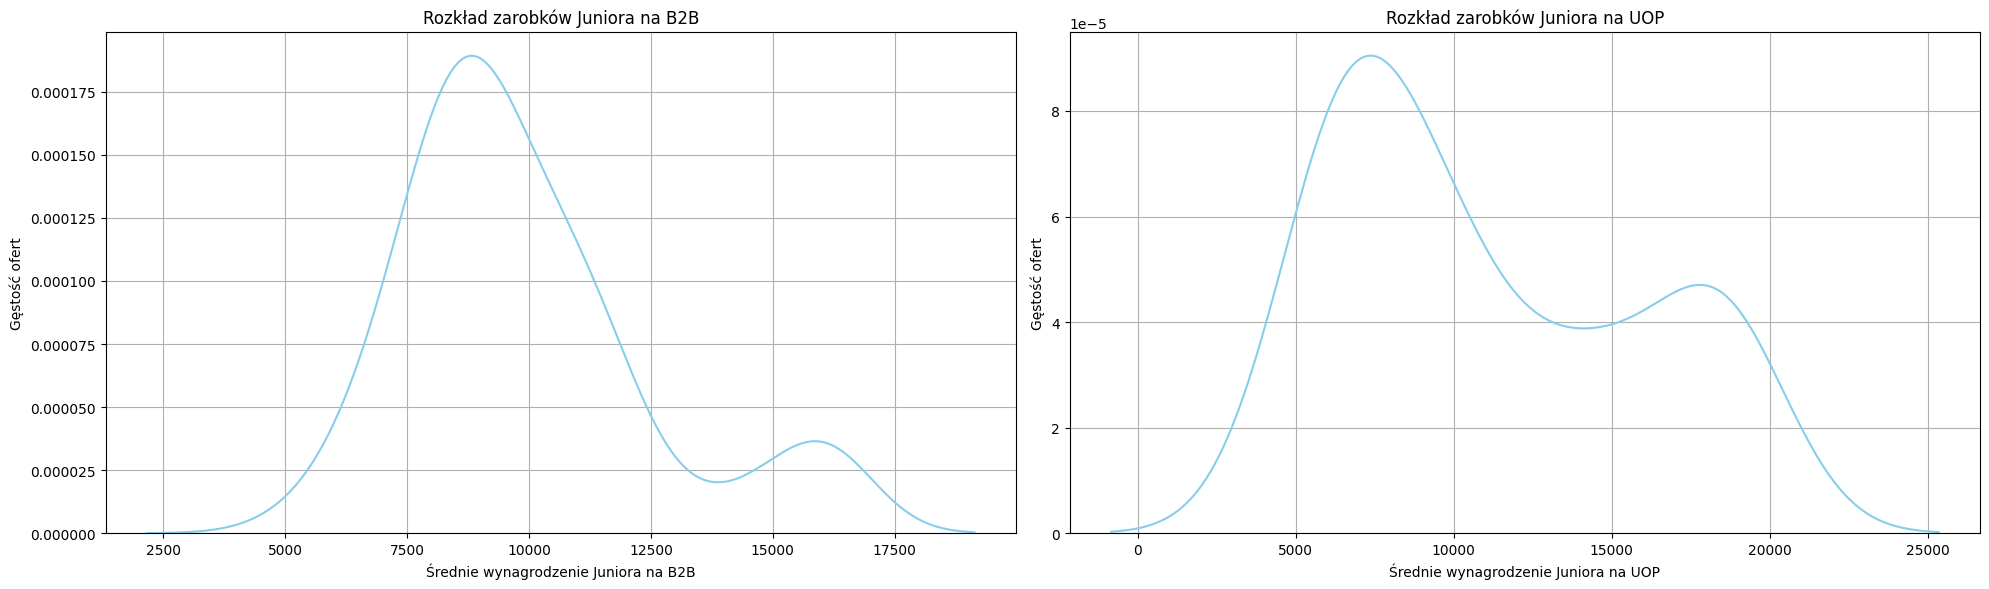

In [1467]:
salary_distribution(df, "Mid")
salary_distribution(df, "Senior")
salary_distribution(df, "Junior")

# Rozkład popularności technologii

In [1468]:
def popularity(data, start_column, end_column, title, xlabel, ylabel, figsize=(22, 6), color='blue'):
    technologies = data.loc[:, start_column:end_column]

    sum_of_tech = technologies.sum().sort_values(ascending=False)

    plt.figure(figsize=figsize)
    sum_of_tech.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/rozkłady/{title.lower().replace(" ", "_")}.png")
    plt.show()


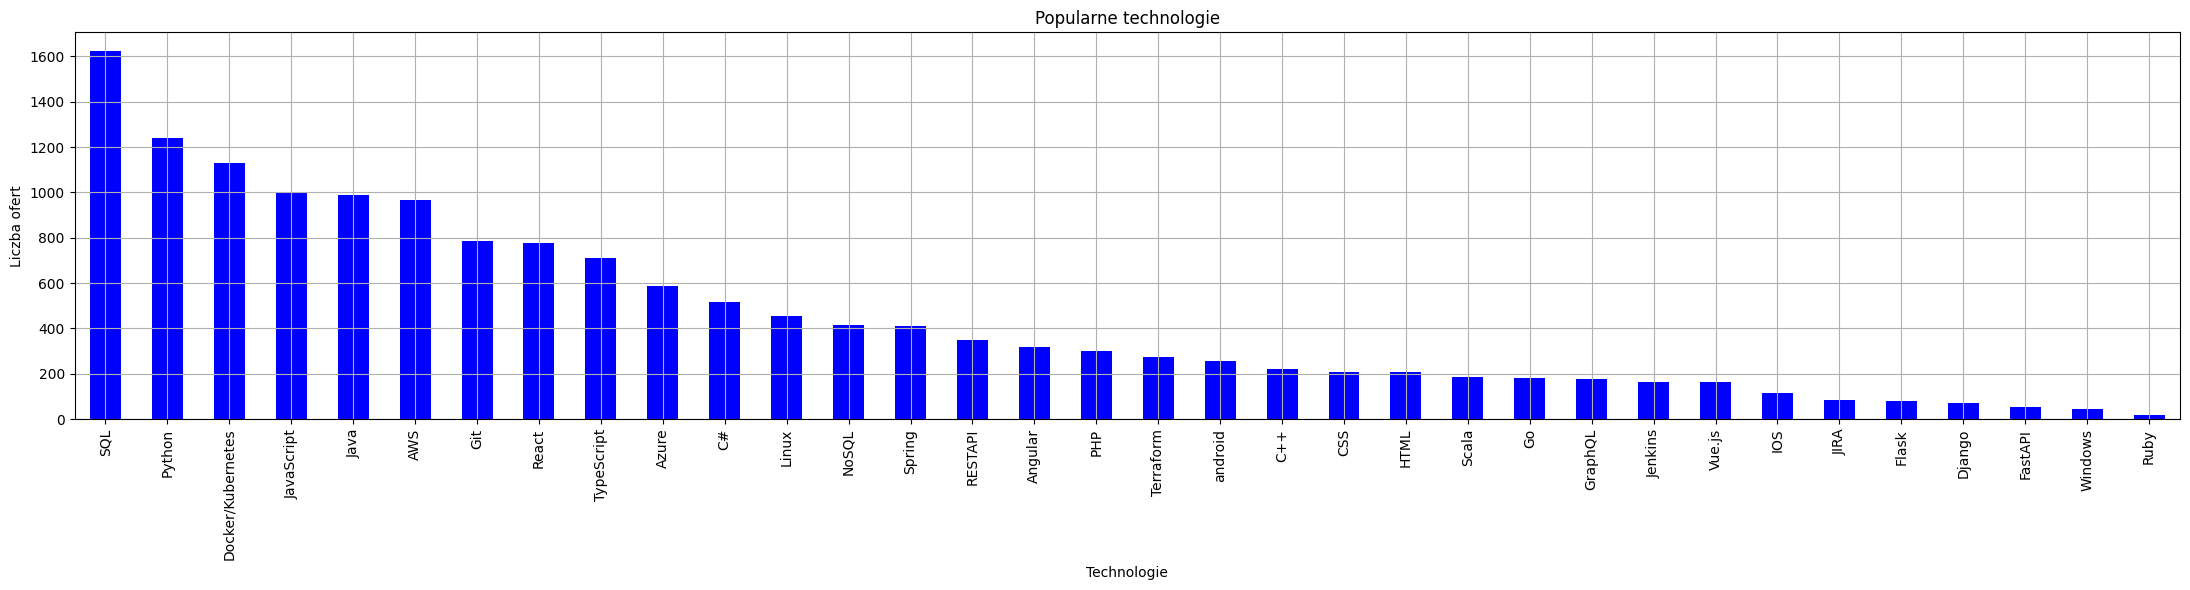

In [1469]:
popularity(df, 'AWS', 'android', 'Popularne technologie', 'Technologie', 'Liczba ofert')

# Rozkład lokalizacji

Warszawa     827
Kraków       658
Wrocław      597
Gdańsk       494
Poznań       489
Katowice     327
Łódź         279
Rzeszów      191
Lublin       172
Bydgoszcz    116
Białystok     99
Toruń         68
Name: count, dtype: int64


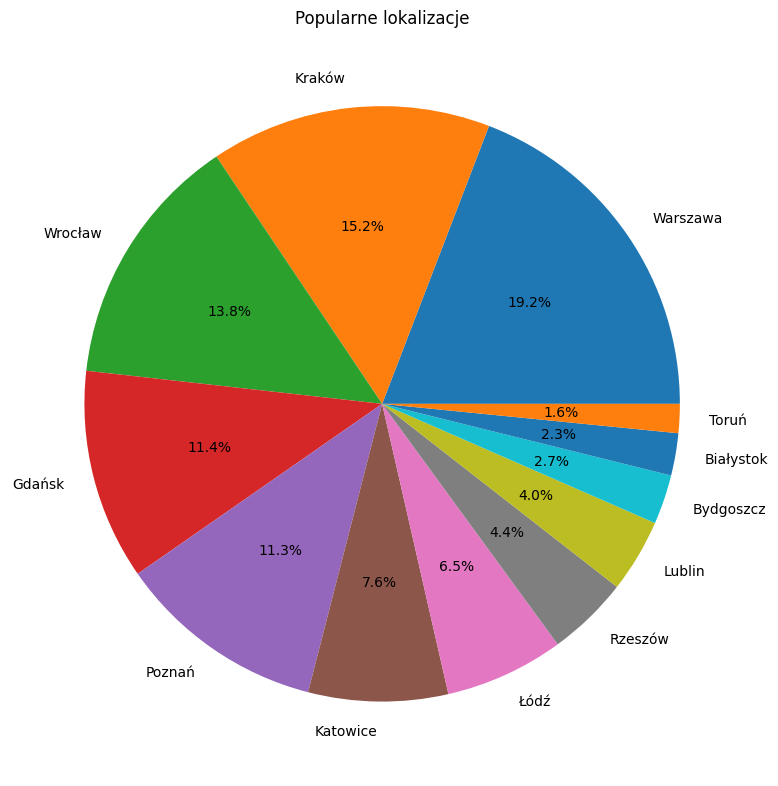

In [1470]:
get_histogram(df, 'location_code', 'Popularne lokalizacje', location_encoder, label_x="", label_y="")

Experience: 0
Warszawa     27
Wrocław      20
Katowice     15
Kraków       15
Gdańsk       14
Poznań       14
Łódź          6
Rzeszów       6
Toruń         5
Gliwice       5
Lublin        3
Białystok     2
Name: count, dtype: int64


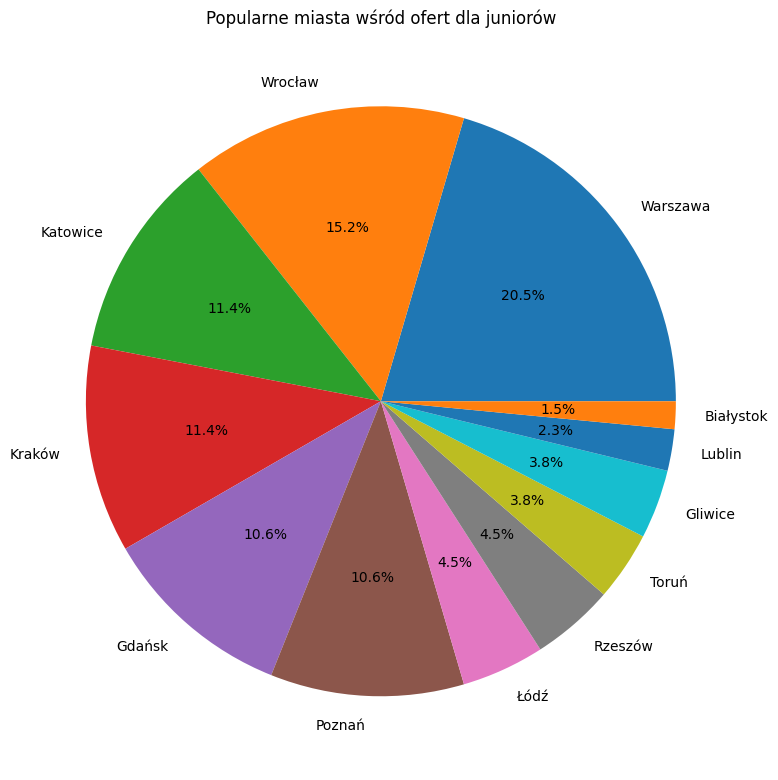

In [1471]:
get_histogram(df, 'location_code', 'Popularne miasta wśród ofert dla juniorów', location_encoder, label_x="", label_y="", is_specified=True, exp="Junior")

# Macierz korelacji techonlogii

Czy jakieś techonologie idą ze sobą w parze.


In [1472]:
def create_corr_plot(corr, title, size=(20,20)):
    plt.figure(figsize=size)
    sns.heatmap(corr, annot=True,fmt=".2f", linecolor="lightgrey", linewidths=0.5, cmap="flare")
    sns.color_palette("flare", as_cmap=True)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"plots/korelacje/{title.lower().replace(" ", "_")}.png")
    plt.show()

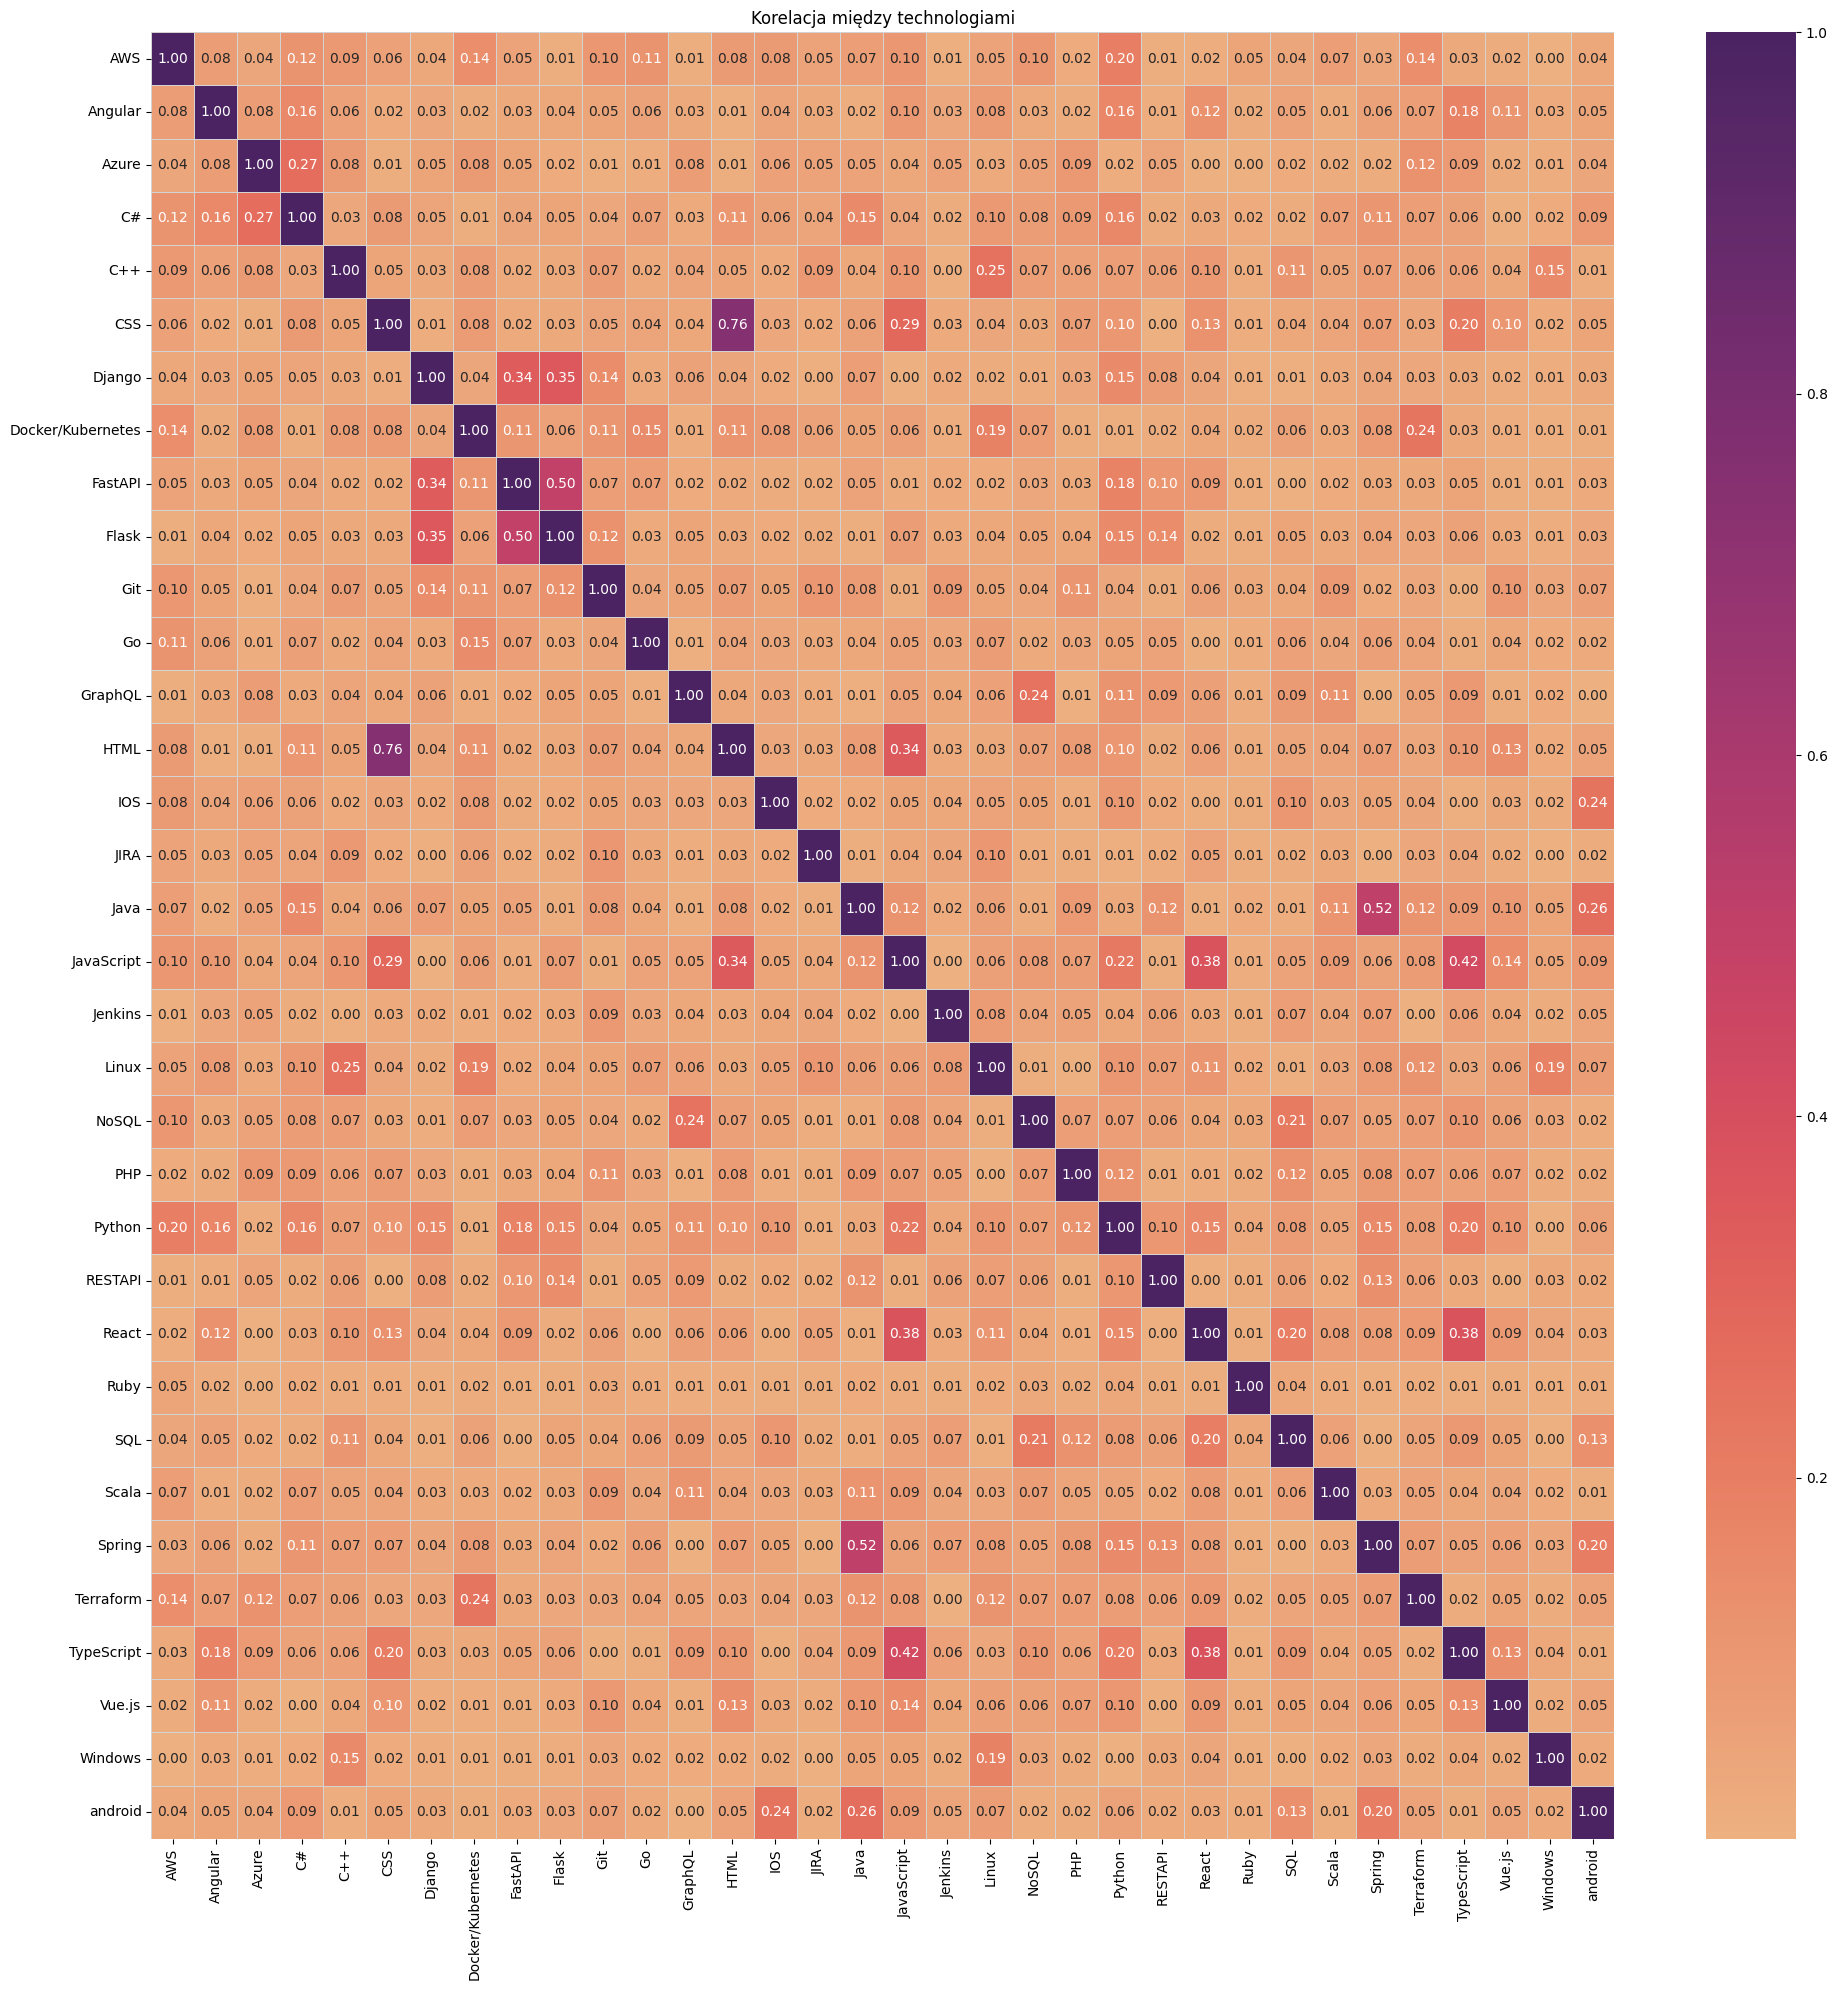

In [1473]:
# Obliczenie korelacji między wybranymi kolumnami
technologies = df.loc[:, "AWS": "android"].columns.tolist()
corr = df[technologies].corr()
corr = corr.abs()
create_corr_plot(corr, 'Korelacja między technologiami')


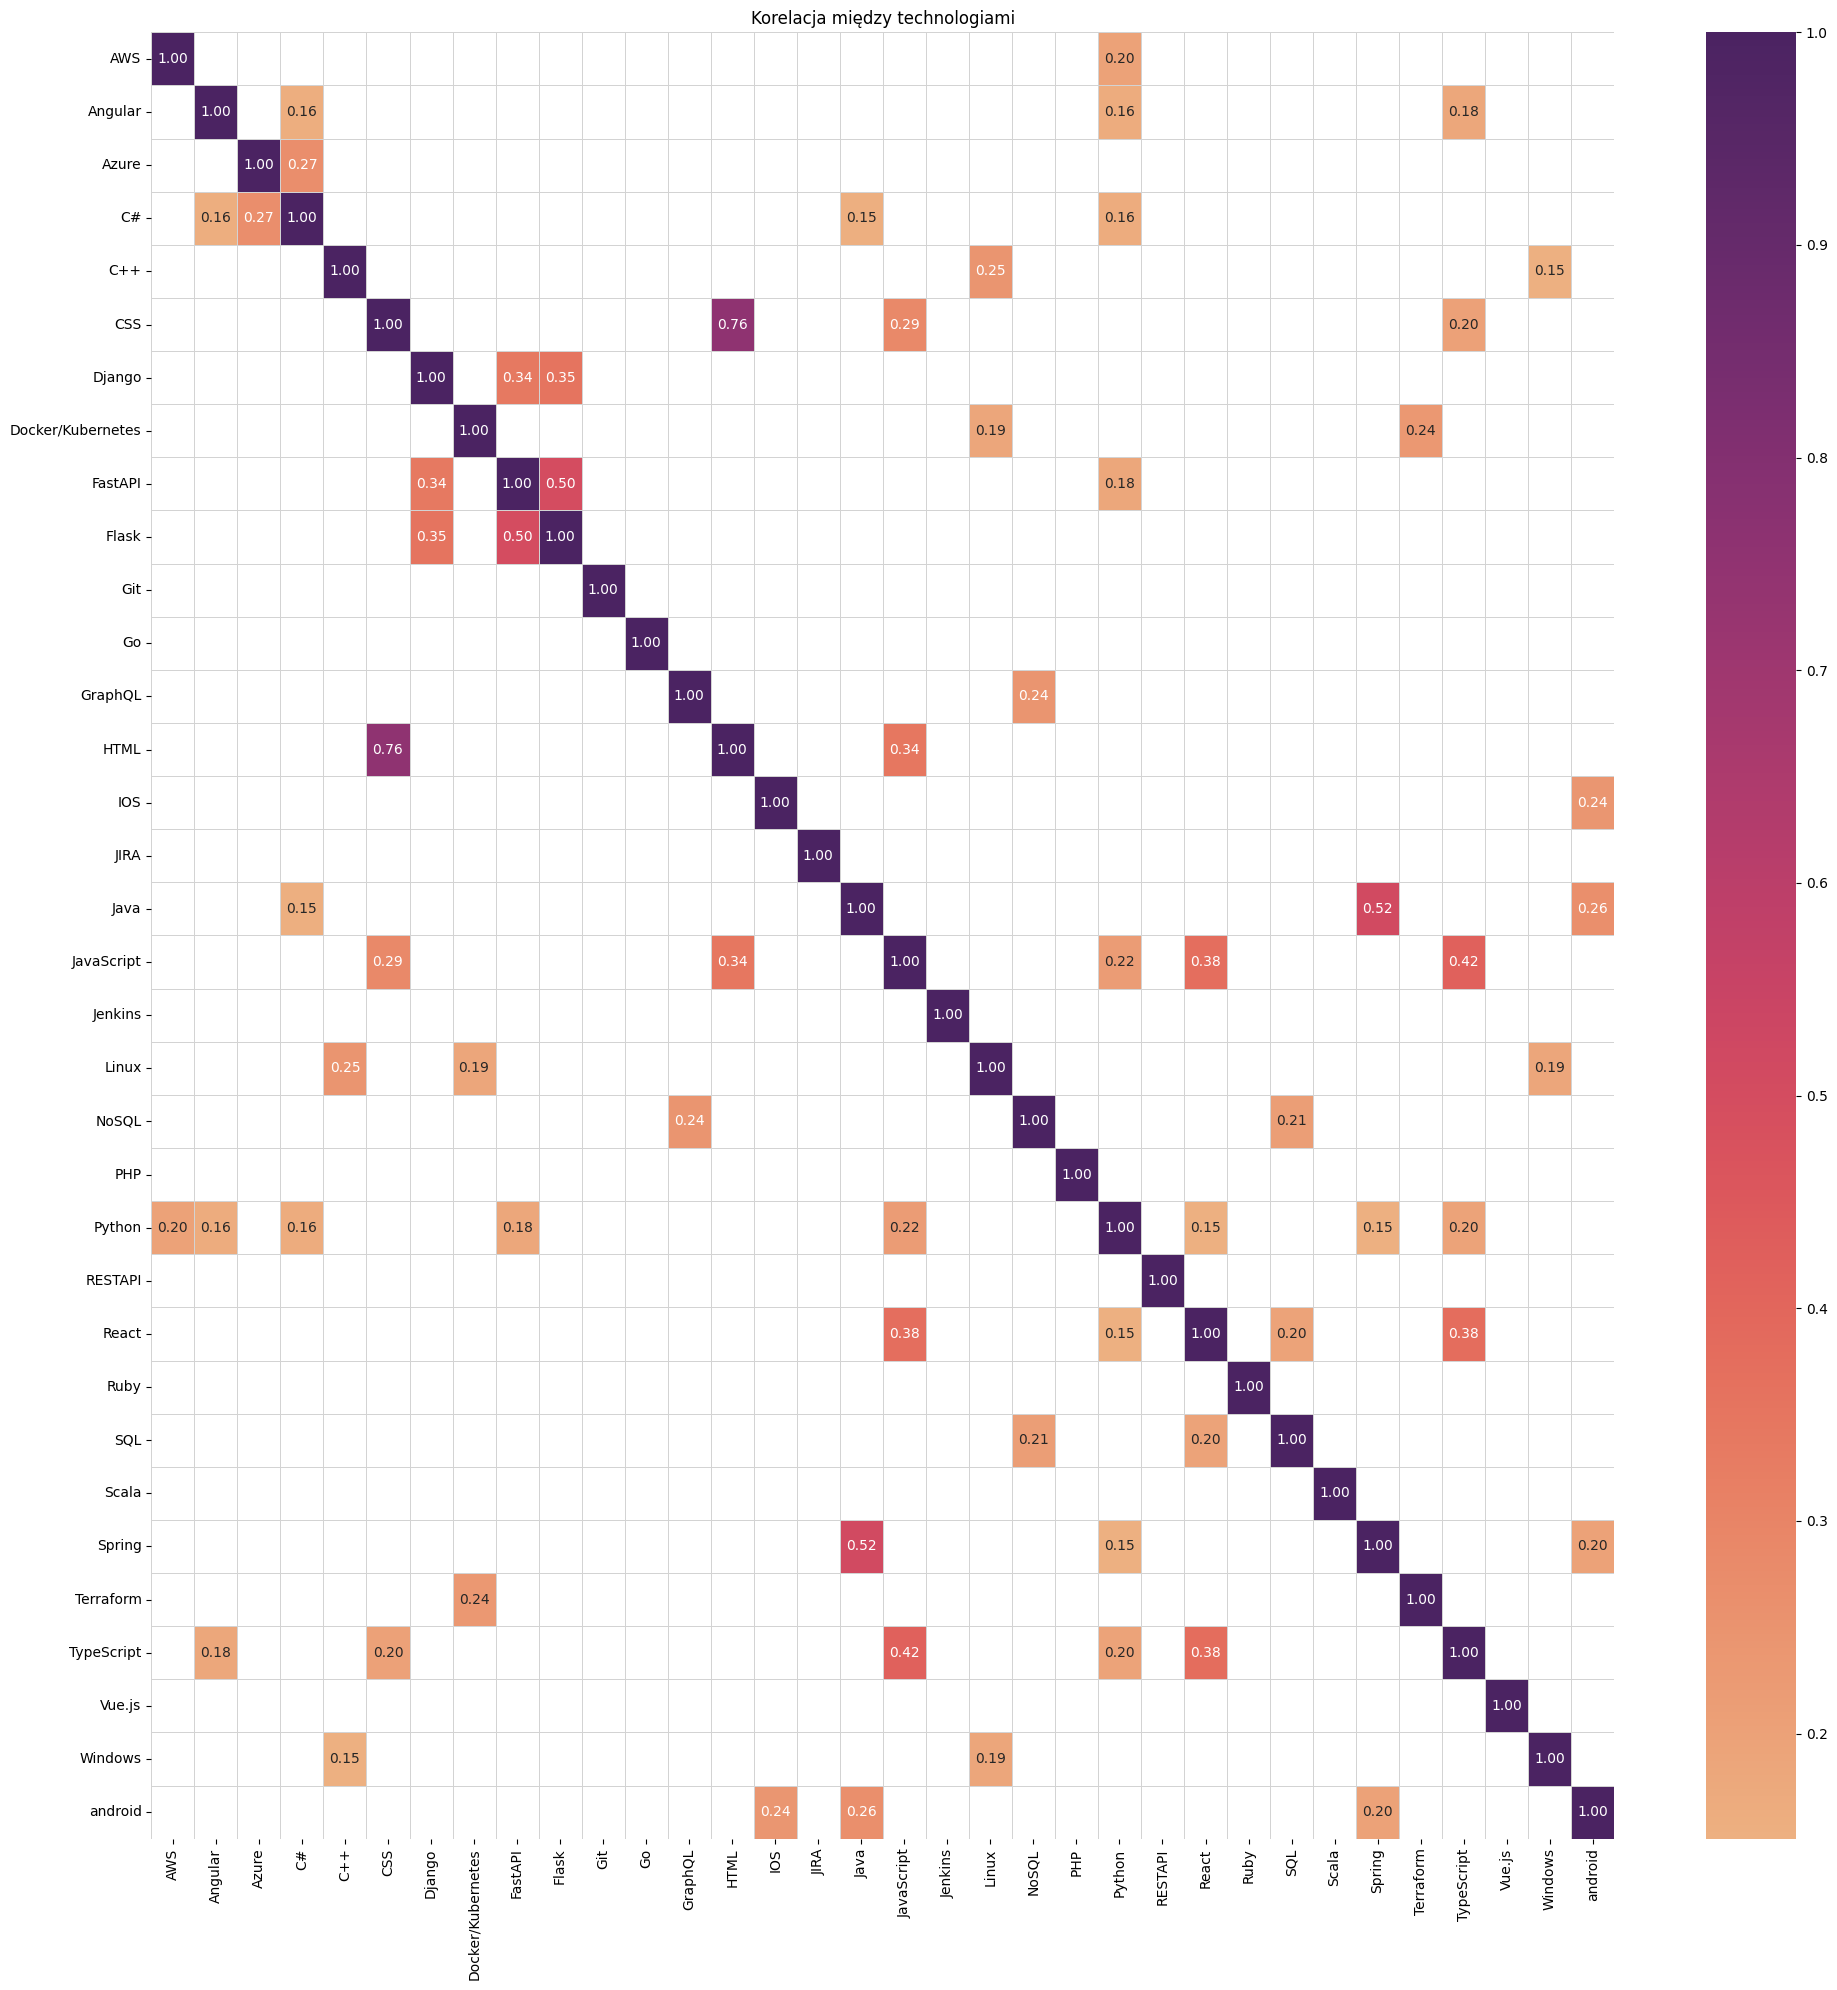

In [1474]:
technologies = df.loc[:, "AWS": "android"].columns.tolist()
corr_matrix = df[technologies].corr().abs()

mask = corr_matrix > 0.15

filtered_corr = corr_matrix[mask]

create_corr_plot(filtered_corr, 'Korelacja między technologiami')

# Macierz korelacji wybranych zmiennych

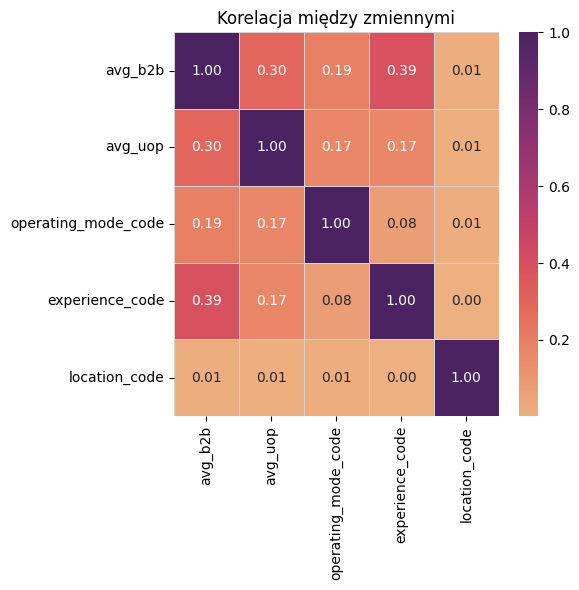

In [1475]:
data["avg_b2b"] = data[["min_b2b", "max_b2b"]].mean(axis=1)
data["avg_uop"] = data[["min_uop", "max_uop"]].mean(axis=1)

vars = ["avg_b2b", "avg_uop", "operating_mode_code", "experience_code", "location_code"]

corr = data[vars].corr()
corr = corr.abs()

create_corr_plot(corr, 'Korelacja między zmiennymi', size=(6,6))



# Zarobki a technologie

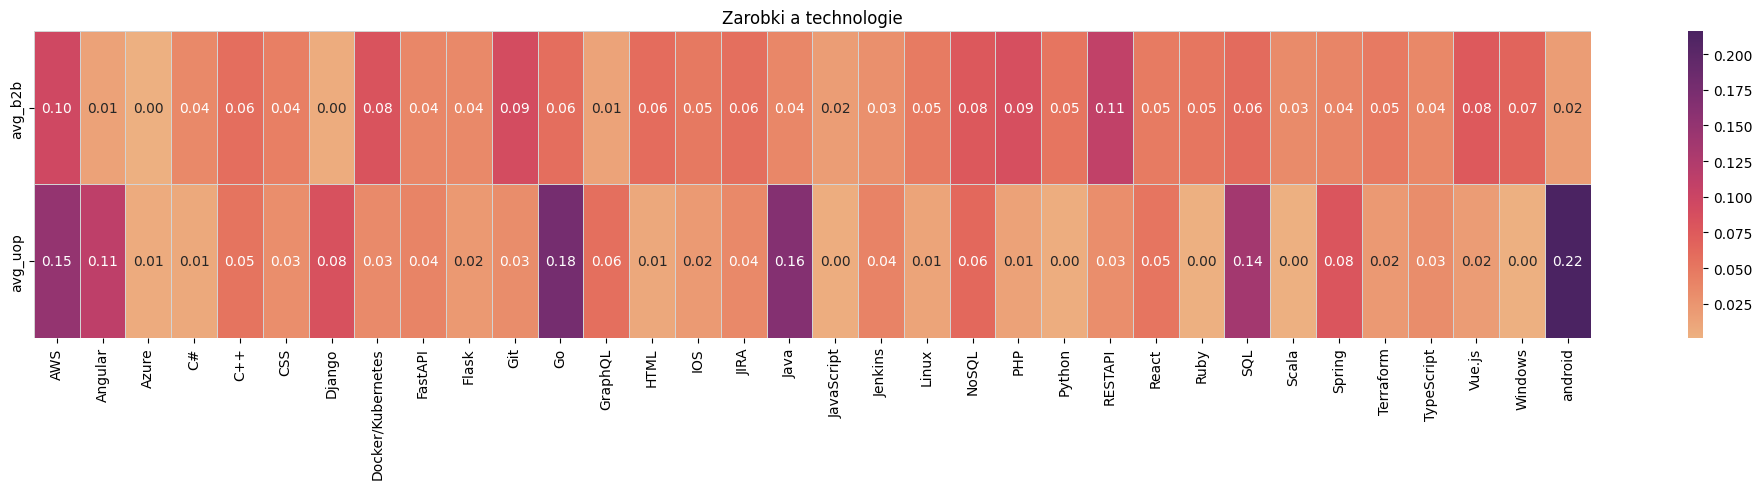

In [1476]:
salaries = ["avg_b2b", "avg_uop"]
techs = data.loc[:, "AWS":"android"]

all_vars = salaries + list(techs.columns)
corr = data[all_vars].corr()
corr = corr.abs()  
corr = corr.loc[salaries, techs.columns] 

create_corr_plot(corr, "Zarobki a technologie", size=(20, 5))



# Korelacja technologii a lokalizacji

/tmp/ipykernel_15136/584414074.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


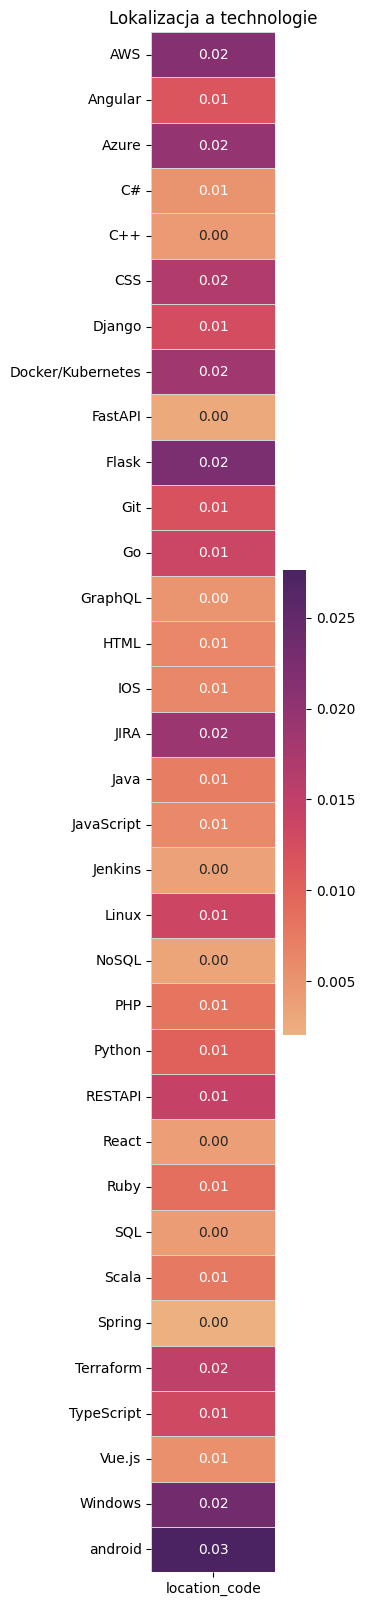

In [1477]:
corr = data[["location_code"] + list(techs.columns)].corr()
corr = corr.abs()
corr = corr.loc[techs.columns, ["location_code"]]
create_corr_plot(corr, "Lokalizacja a technologie", size=(2, 20))

# Przygotowanie modeli

Wybrałem Regresje Liniową, Las losowy i drzewko decyzji.

**Dlaczego?**

- Regresja liniowa: jest to najprostszy model regresji, który zakłada liniową zależność między zmiennymi i pojawiła się na zajęciach.

- Random Forest: podobno skuteczny model (z polecenia znajomego), który jest złożeniem wielu drzew decyzyjnych.

- Drzewo decyzyjne: jest to najprostszy model, który zakłada, że dane są liniowe.


Nie wykluczam, ze będę testował inne modele, ale na razie zacznę od tych trzech.

Inne modele, które mogę przetestować:

- Lasso
- Ridge

In [1478]:
models_to_tune = {
    'Linear_Regression':{
        'model':LinearRegression(),
        'params':{}
    },
    'Decision_Tree':{
        'model':DecisionTreeRegressor(),
        'params':{
            'max_depth':[2,4,6,8,10],
            'random_state':[0,42],
            'min_samples_split':[2,5,10,20]
        }
    },
    'Random_Forest':{
        'model':RandomForestRegressor(n_estimators=20),
        'params':{
            'n_estimators':[10,30,20,50,80]
        }
    },
    'Ridge':{
        'model':Ridge(alpha=.1),
        'params':{
            'alpha':[0.1,0.5,1,2,5,10]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 0.5, 1, 2, 5, 10]
        }
    }
}

In [1479]:
# Hyper parameter tuning through grid search cv
from sklearn.model_selection import GridSearchCV


def tune_models(x_train, y_train):
    scores = []

    for name, value in models_to_tune.items():
        clf = GridSearchCV(value['model'], value['params'], cv=5, scoring='neg_mean_squared_error')
        clf.fit(x_train, y_train)

        scores.append({
            'Model': name,
            'Params': clf.best_params_,
            'MSE(-ve)': clf.best_score_
        })
    pd.DataFrame(scores).to_csv("models_tuning.csv", index=False)

In [1480]:
parameters_for_models = pd.read_csv('models_tuning.csv')

model_params = {}

for index, row in parameters_for_models.iterrows():
    model_name = row['Model']
    params = eval(row['Params'])
    model_params[model_name] = params

n_estimators = model_params['Random_Forest']['n_estimators']

max_depth = model_params['Decision_Tree']['max_depth']
min_samples_split = model_params['Decision_Tree']['min_samples_split']
random_state = model_params['Decision_Tree']['random_state']

alpha_ridge = model_params['Ridge']['alpha']

alpha_lasso = model_params['Lasso']['alpha']

models = [
    LinearRegression(), DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, random_state=random_state),
    RandomForestRegressor(n_estimators=n_estimators), Ridge(alpha=alpha_ridge),
    Lasso(alpha=alpha_lasso)
]

In [1481]:
class Plotter:
    
    def __init__(self, data, y_pred, y_train, y_test, test_size, model_title, contract) -> None:
        self.data = data
        self.y_pred = y_pred
        self.y_train = y_train
        self.y_test = y_test
        self.test_size = test_size
        self.model_title = model_title
        self.contract = contract
        self.dest = f"plots/wyniki/{1-self.test_size}&{self.test_size}/{self.contract}/{self.model_title}/"
        
        import os
        if not os.path.exists(self.dest):
            os.makedirs(self.dest)
            
    
    def get_plots(self):
        self.plot_salary_distribution()
        self.plot_with_errors()
        self.scatter_plot()
    
    def plot_salary_distribution(self):
        if self.contract == "b2b":
            real_salaries = self.data[self.data["avg_b2b"] > 0]["avg_b2b"]
        else:
            real_salaries = self.data[self.data["avg_uop"] > 0]["avg_uop"]

        plt.figure(figsize=(14, 6))

        sns.kdeplot(real_salaries, color='blue', label=f"Rzeczywiste zarobki na {self.contract}")

        sns.kdeplot(self.y_pred, color='orange', label=f"Przewidziane zarobki na {self.contract}")

        plt.title(f"Rozkład dla {self.model_title}")
        plt.xlabel(f"Zarobki (PLN) na {self.contract}")
        plt.ylabel("Gęstość ofert")
        plt.legend()

        plt.tight_layout()
        plt.savefig(self.dest + "salary_dist.png")
        plt.show()

    
    def plot_with_errors(self):
        errors = self.y_test - self.y_pred   
        plt.hist(errors, bins='auto')
        plt.xlabel('Przedziały błędów predykcji')
        plt.ylabel('Ilość')
        plt.title(f'Histogram błędów predykcji dla {self.model_title}')
        plt.savefig(self.dest + "errors.png")
        plt.show()
    
    def scatter_plot(self):
        plt.scatter(self.y_test, self.y_pred)
        plt.xlabel('Prawdziwe dane')
        plt.ylabel('Przewidziane dane')
        plt.plot([self.y_test.min(), self.y_test.max()], [self.y_test.min(), self.y_test.max()], color='red') 
        plt.title(f'Prawdziwe vs Przewidziane zarobki na {self.contract} dla {self.model_title}')
        plt.savefig(self.dest + "scatter.png")
        plt.show()

# Wybieramy najlepszy model

Tutaj to zalezy od danych wejściowych, czasami zwraca Regresje Liniową, a czasami Random Forest.

In [1482]:
def get_best_model(models, x_train, x_test, y_train, y_test, short=True, contract="b2b", test_size=0.2):    
    metrics_list = []
    
    def eval_model(model, x_train, x_test, y_train, y_test):
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
        y_pred = model.predict(x_test)
        metrics = {
            "Model": model.__class__.__name__,
            "Mean Absolute Error": mean_absolute_error(y_test, y_pred).round(2),
            "Root Mean Squared Error": np.sqrt(mean_squared_error(y_test, y_pred)).round(2),
            "R^2 Score": r2_score(y_test, y_pred)
        }
        
        plotter = Plotter(data=None, y_pred=y_pred, y_train=y_train, y_test=y_test, test_size=test_size, model_title=model.__class__.__name__, contract=contract)
        plotter.get_plots()
        
        return score, metrics

    best_score = float('-inf')
    best_model = None
    best_metrics = None

    for model in models.values():
        score, metrics = eval_model(model, x_train, x_test, y_train, y_test)
        if score > best_score:
            best_score = score
            best_model = model
            best_metrics = metrics
        metrics_list.append(metrics)
    
    metrics_df = pd.DataFrame(metrics_list)
    dest = f"plots/wyniki/{1-test_size}&{test_size}/{contract}/metrics.csv"
    metrics_df.to_csv(dest, index=False)
                
    return best_model

In [1483]:
def create_model_other_method(data, contract_type="b2b", test_size=0.2):
    tmp_data = data.copy()
    
    if contract_type == "b2b":
        tmp_data = tmp_data.loc[tmp_data['avg_b2b'] != 0]
    else:
        tmp_data = tmp_data.loc[tmp_data['avg_uop'] != 0]
    
    features = tmp_data.drop(columns=["avg_b2b", "avg_uop", "title", 'min_b2b', 'max_b2b', 'min_uop', 'max_uop'], axis=1)
    lables = tmp_data[['avg_b2b', 'avg_uop']]
    
    salary = lables["avg_b2b"] if contract_type == "b2b" else lables["avg_uop"]
    
    x_train, x_test, y_train, y_test = train_test_split(features, salary, test_size=test_size, random_state=42)
    
    best_model = get_best_model(models, x_train, x_test, y_train, y_test, short=False, contract=contract_type, test_size=test_size)
    
    return best_model

In [1484]:
def preprocess_input(**params):
  location_code = location_encoder.transform([params["location"]])[0]
  exp_code = exp_encoder.transform([params["exp"]])[0]
  operating_mode_code = mode_encoder.transform([params["operating_mode"]])[0]
  tech_stack = mlb.transform([params["tech_stack"]])[0]
  
  res = np.concatenate([[location_code, exp_code, operating_mode_code], tech_stack]).reshape(1, -1)
  return pd.DataFrame(res)

In [1485]:
def plot_impotance(model, data):
    importances = model.feature_importances_
    features = data.columns
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(20, 6))
    plt.title("Feature importances")
    plt.bar(range(data.shape[1]), importances[indices], align="center")
    plt.xticks(range(data.shape[1]), [features[i] for i in indices], rotation=90)
    plt.xlim([-1, data.shape[1]])
    plt.show()

In [1486]:
model = create_model_other_method(data, contract_type="uop", test_size=0.2)

AttributeError: 'list' object has no attribute 'values'

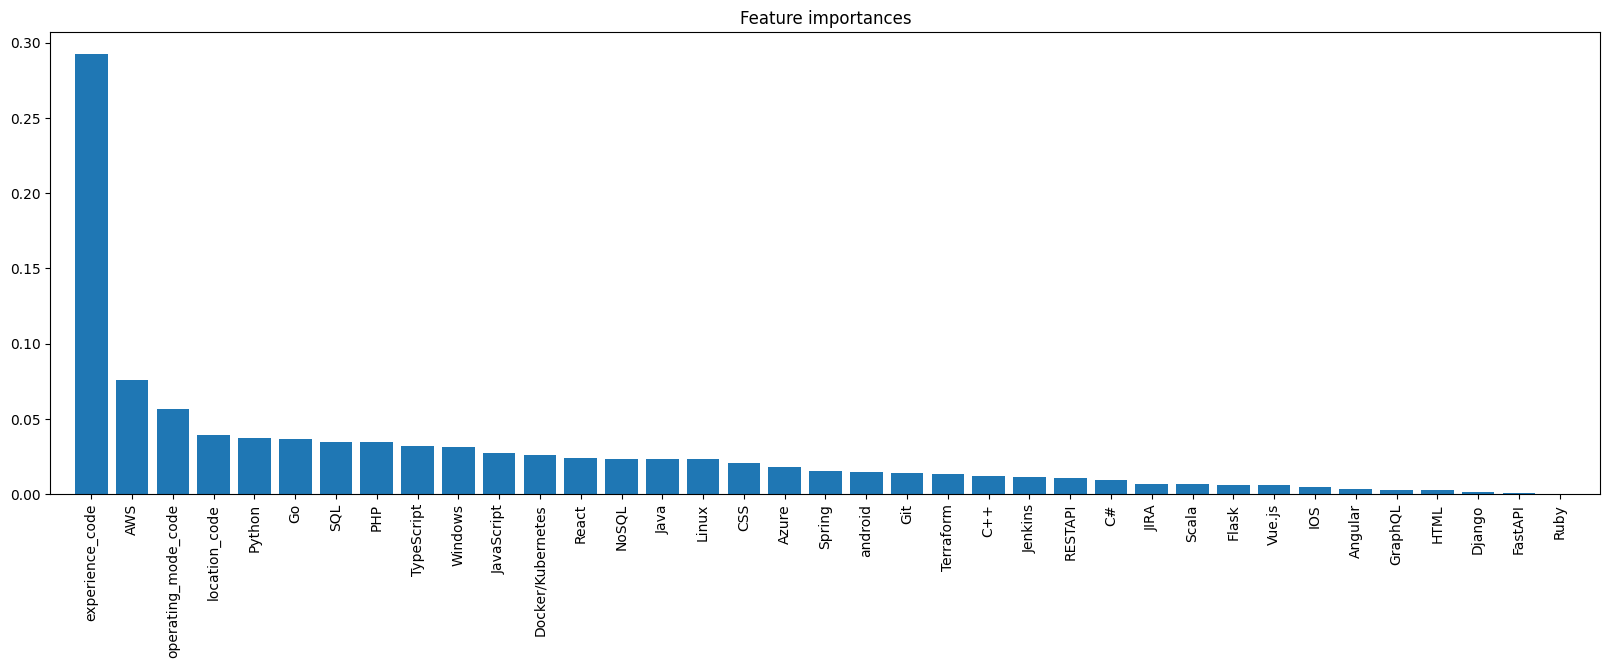

In [ ]:
plot_impotance(model, data.drop(columns=["avg_b2b", "avg_uop", "title", 'min_b2b', 'max_b2b', 'min_uop', 'max_uop'], axis=1))

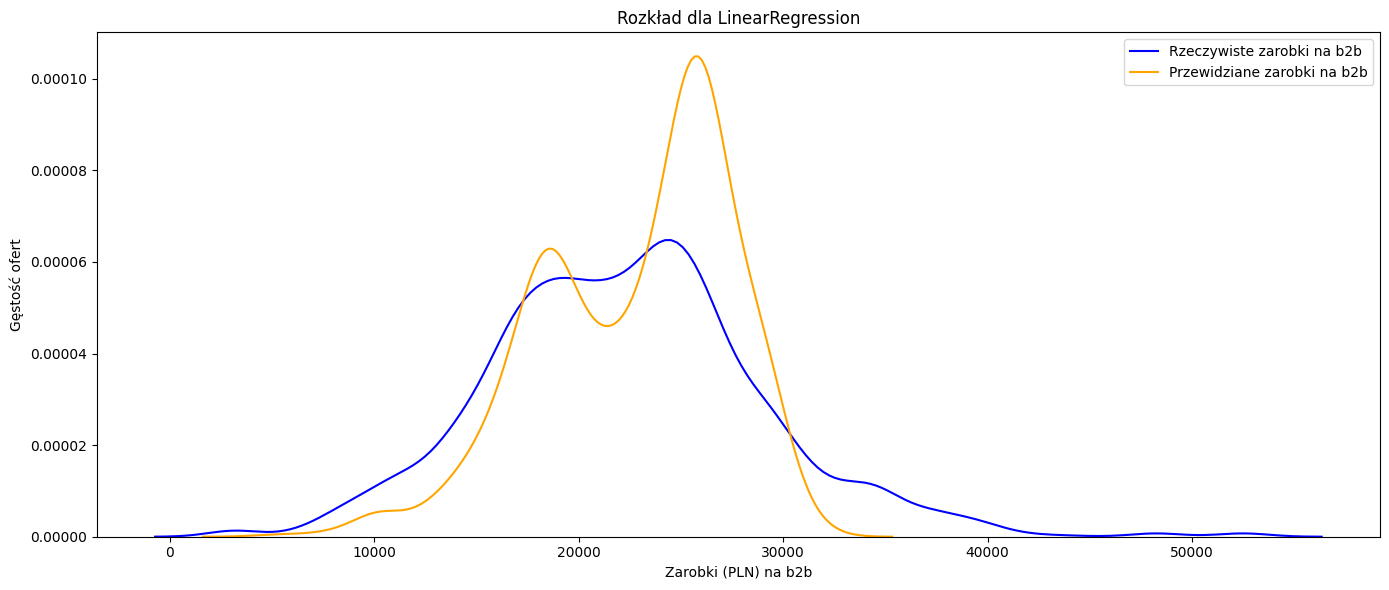

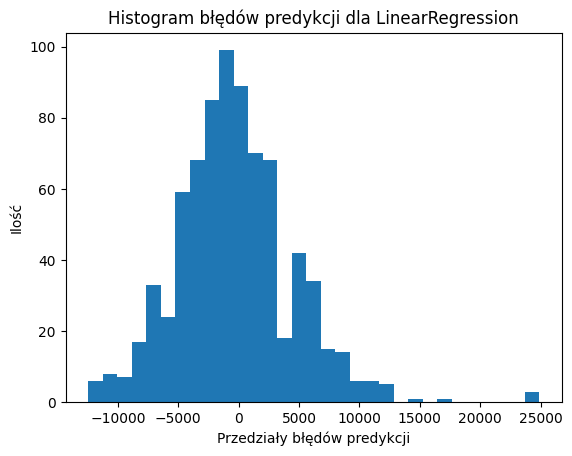

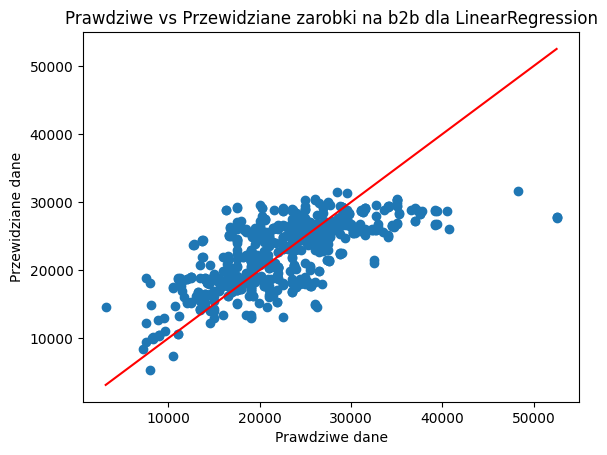

Przetwarzany model: LinearRegression()
Mean Absolute Error : 3636.41
Root Mean Squared Error : 4807.765612007307
R^2 Score : 0.47370299747414957



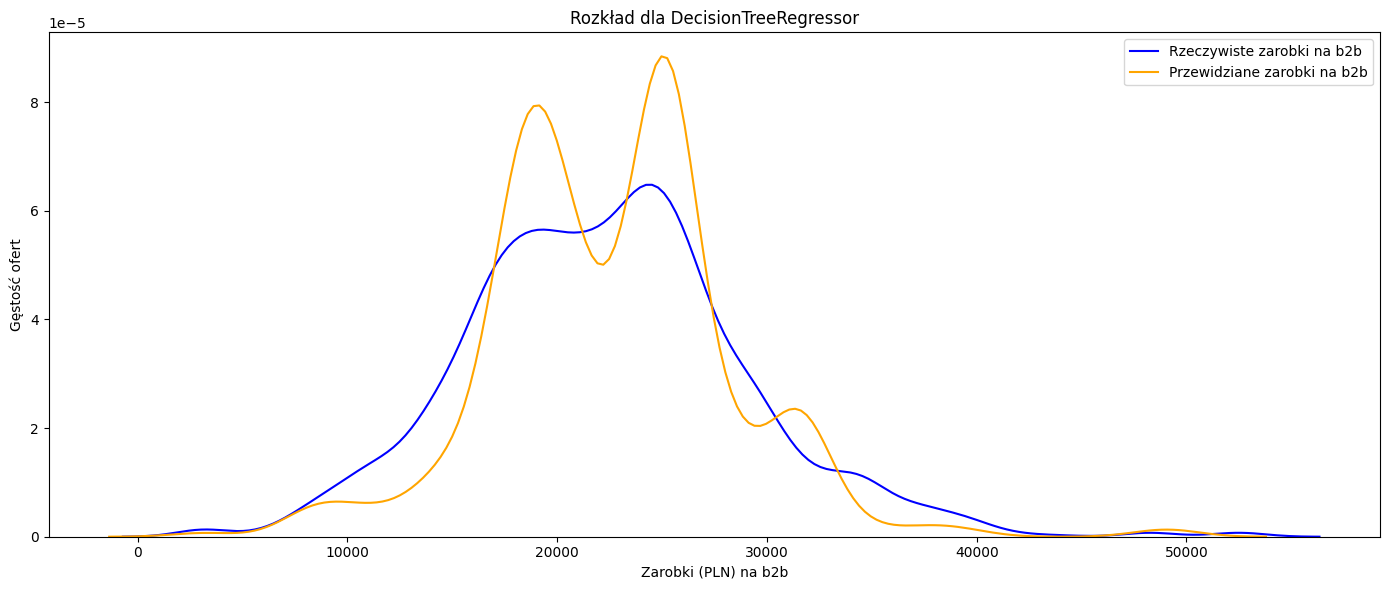

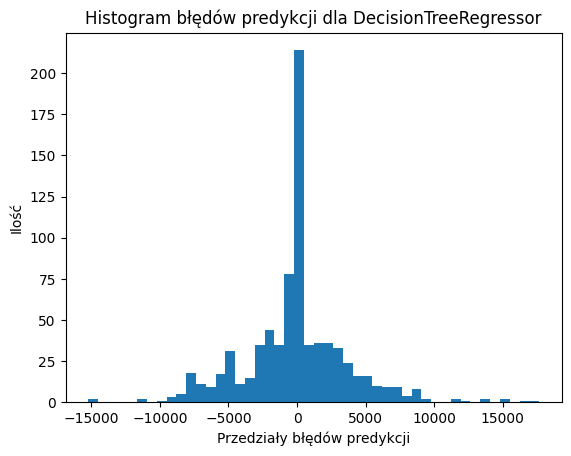

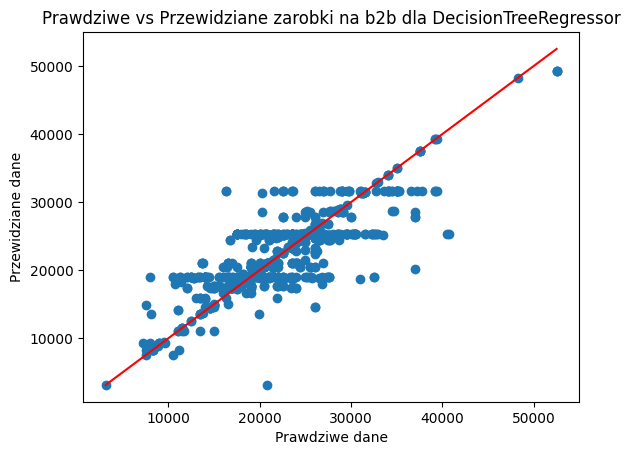

Przetwarzany model: DecisionTreeRegressor(max_depth=10, random_state=42)
Mean Absolute Error : 2516.5
Root Mean Squared Error : 3785.826040641593
R^2 Score : 0.6736635152125181



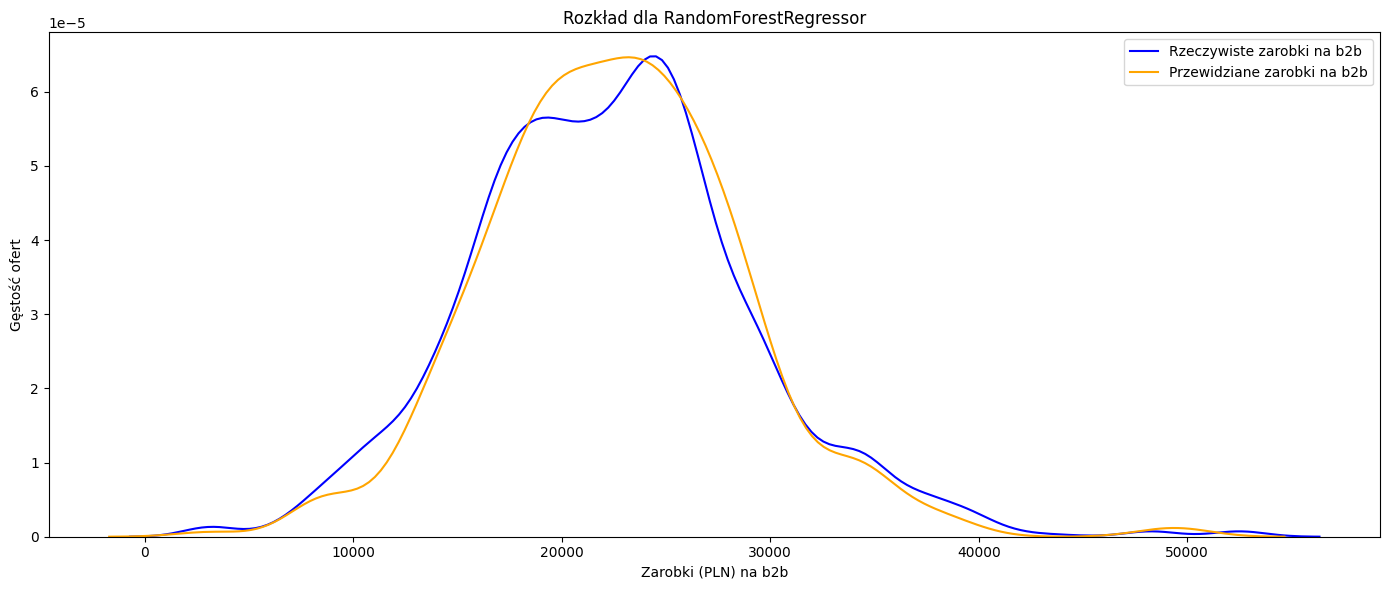

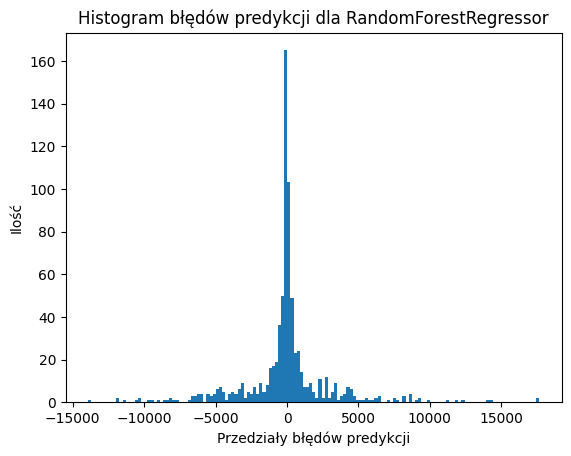

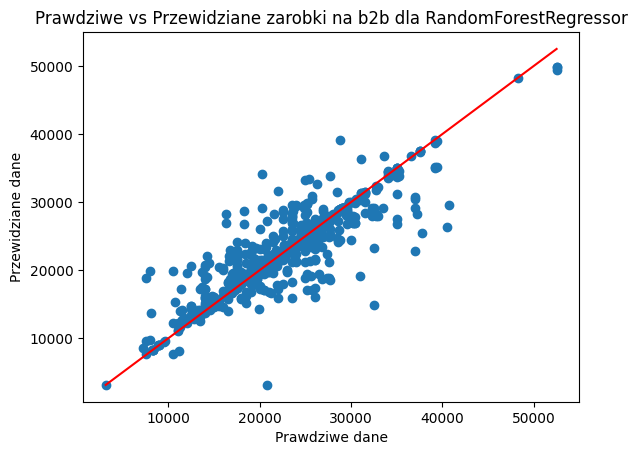

Przetwarzany model: RandomForestRegressor(n_estimators=80)
Mean Absolute Error : 1681.34
Root Mean Squared Error : 3065.9874624662116
R^2 Score : 0.7859648645297892



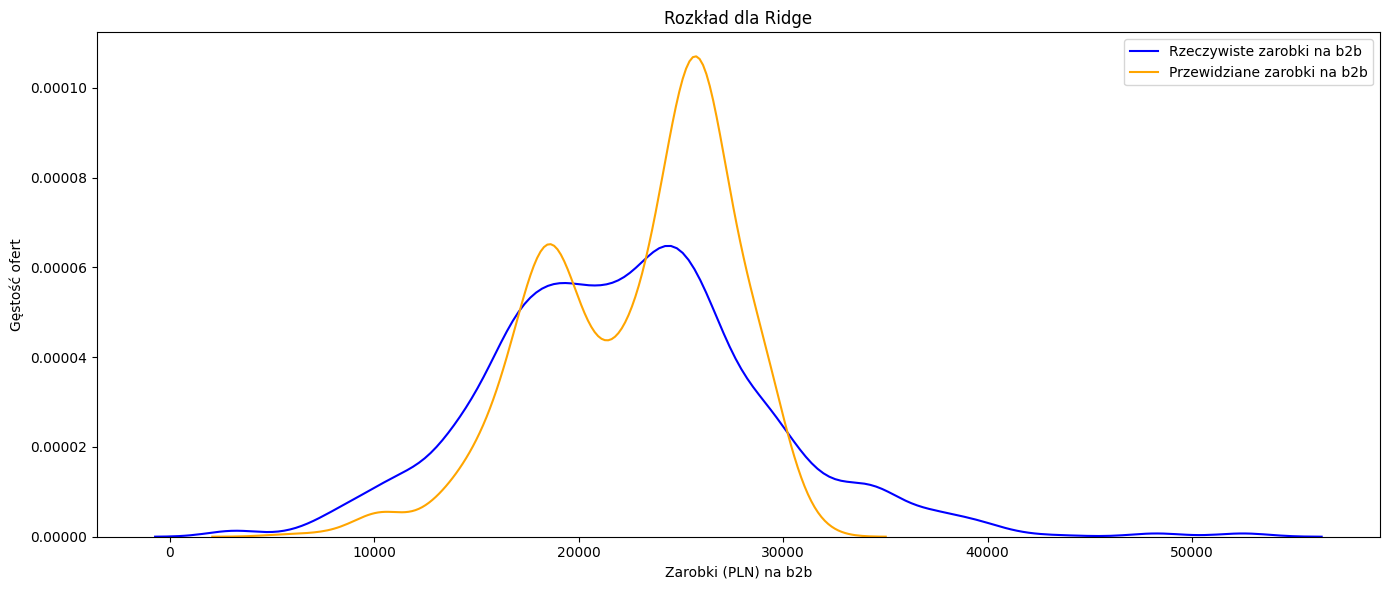

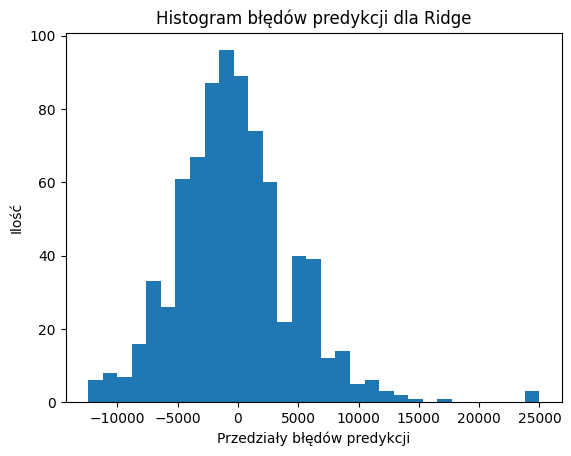

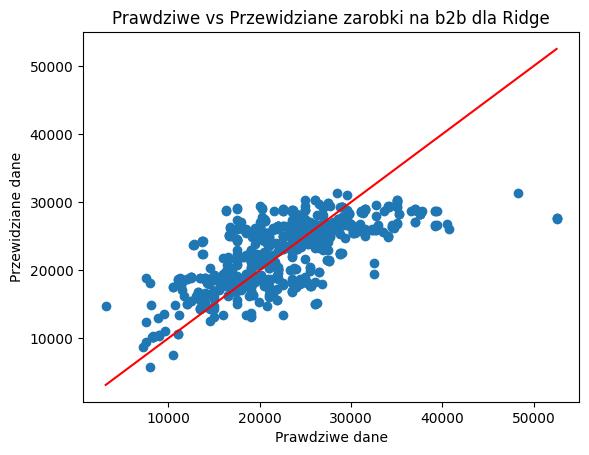

Przetwarzany model: Ridge(alpha=5)
Mean Absolute Error : 3631.55
Root Mean Squared Error : 4812.039857482479
R^2 Score : 0.472766794541008



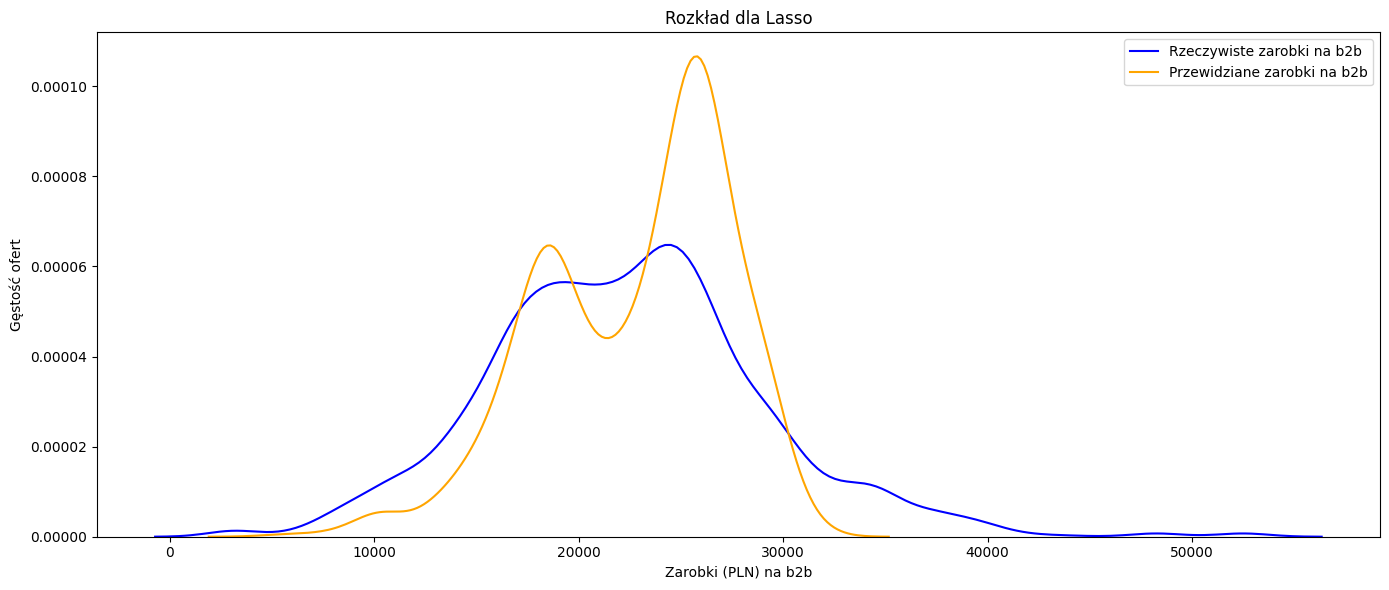

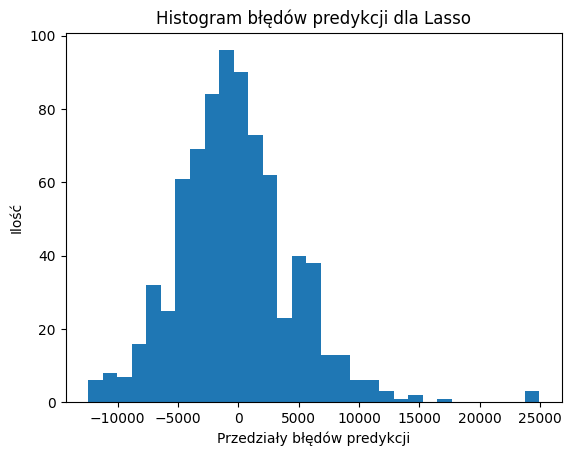

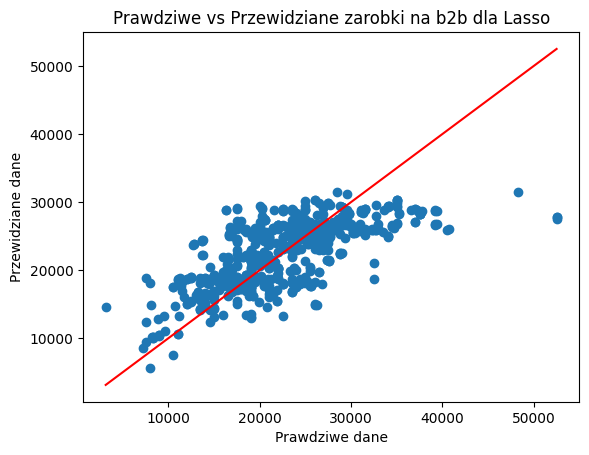

Przetwarzany model: Lasso(alpha=2)
Mean Absolute Error : 3635.49
Root Mean Squared Error : 4820.983172548936
R^2 Score : 0.4708052170239735



In [ ]:
other_model = create_model_other_method(data, contract_type="b2b", test_size=0.2)

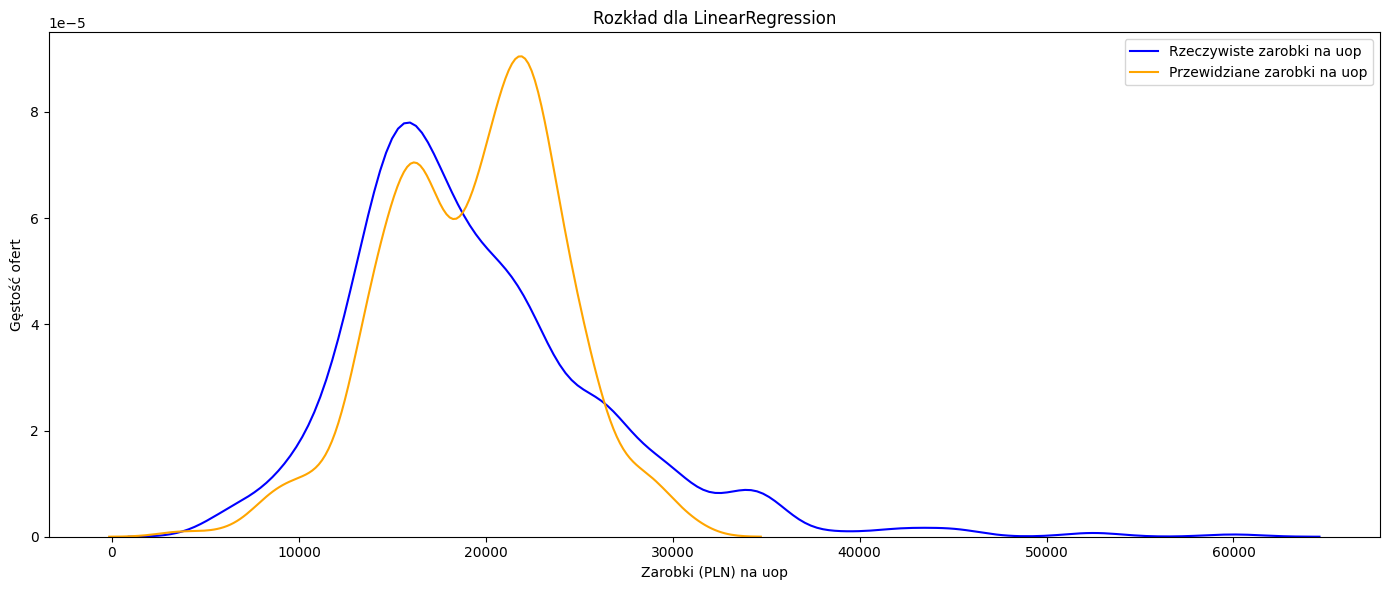

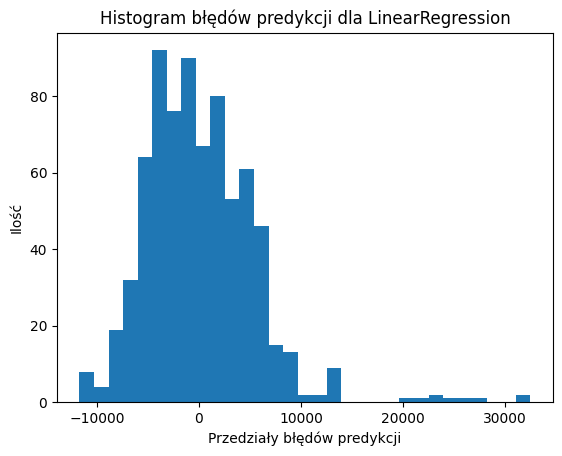

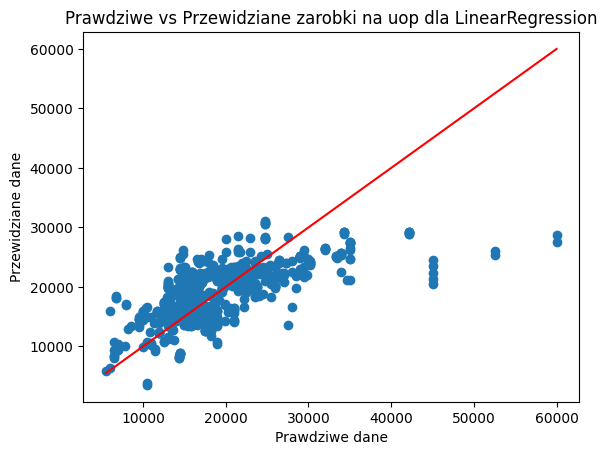

Przetwarzany model: LinearRegression()
Mean Absolute Error : 3994.07
Root Mean Squared Error : 5361.728623307972
R^2 Score : 0.442359152339997



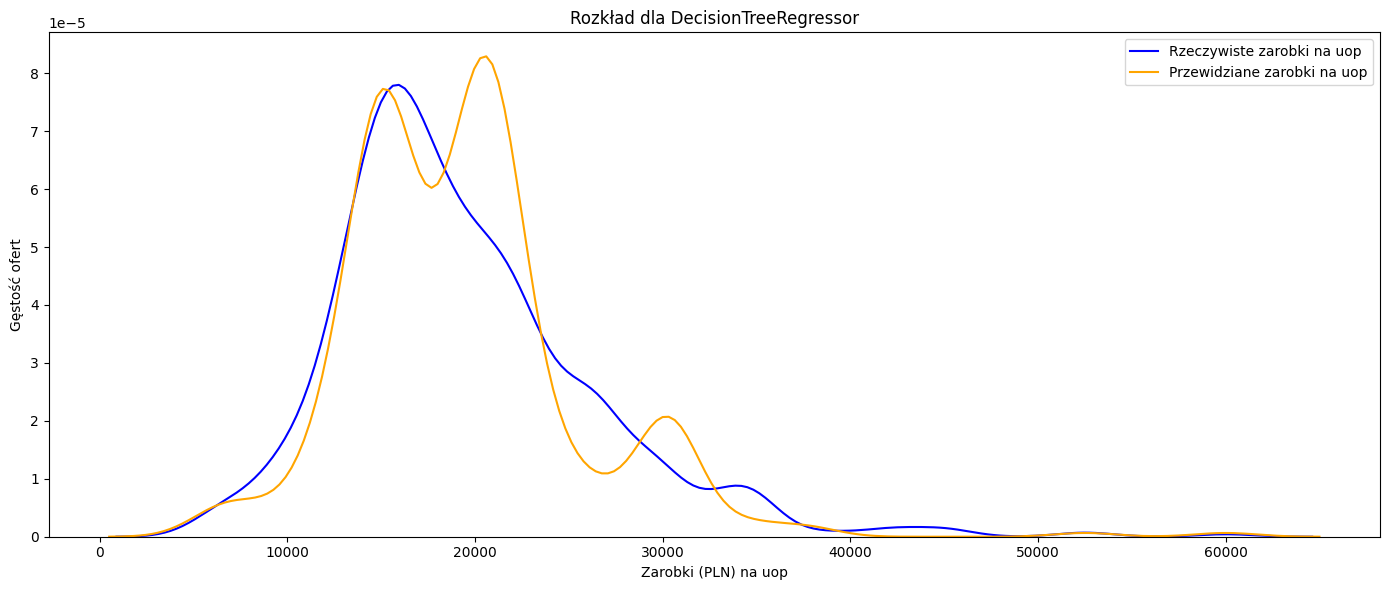

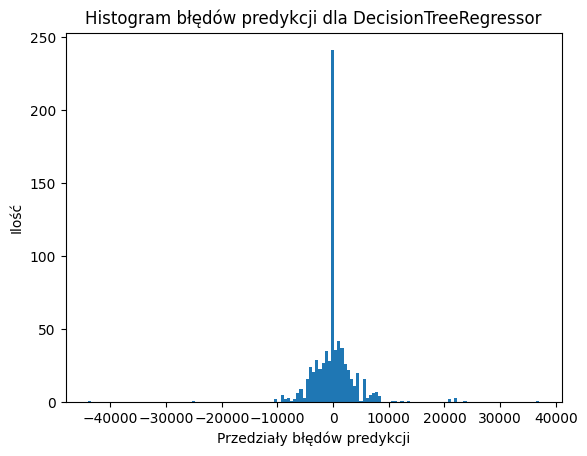

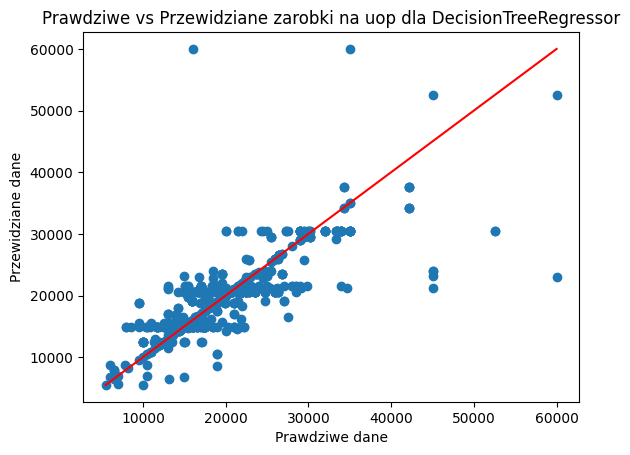

Przetwarzany model: DecisionTreeRegressor(max_depth=10, random_state=42)
Mean Absolute Error : 2312.75
Root Mean Squared Error : 4295.790624553297
R^2 Score : 0.6420427751175559



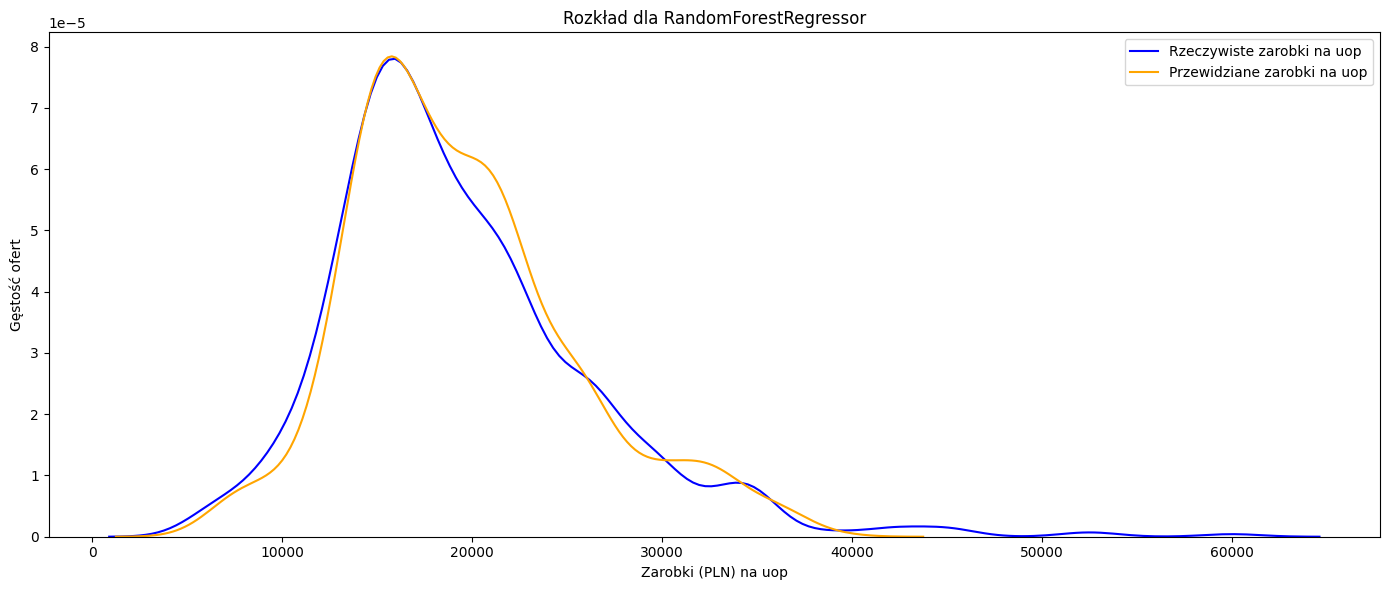

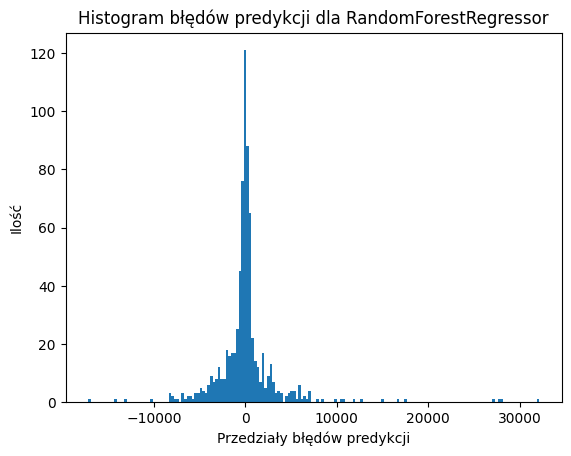

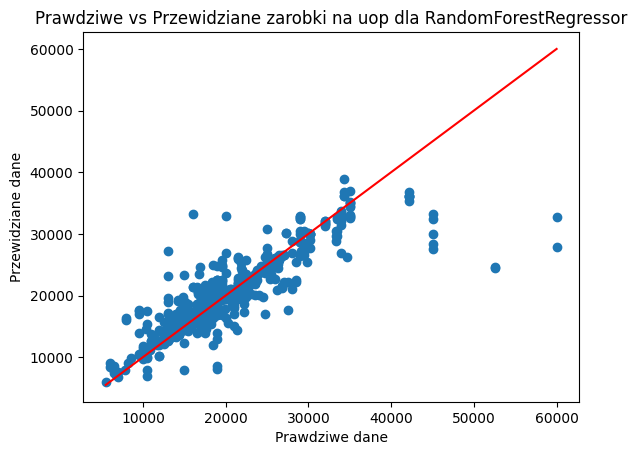

Przetwarzany model: RandomForestRegressor(n_estimators=80)
Mean Absolute Error : 1742.76
Root Mean Squared Error : 3517.1096585122277
R^2 Score : 0.7600522183431122



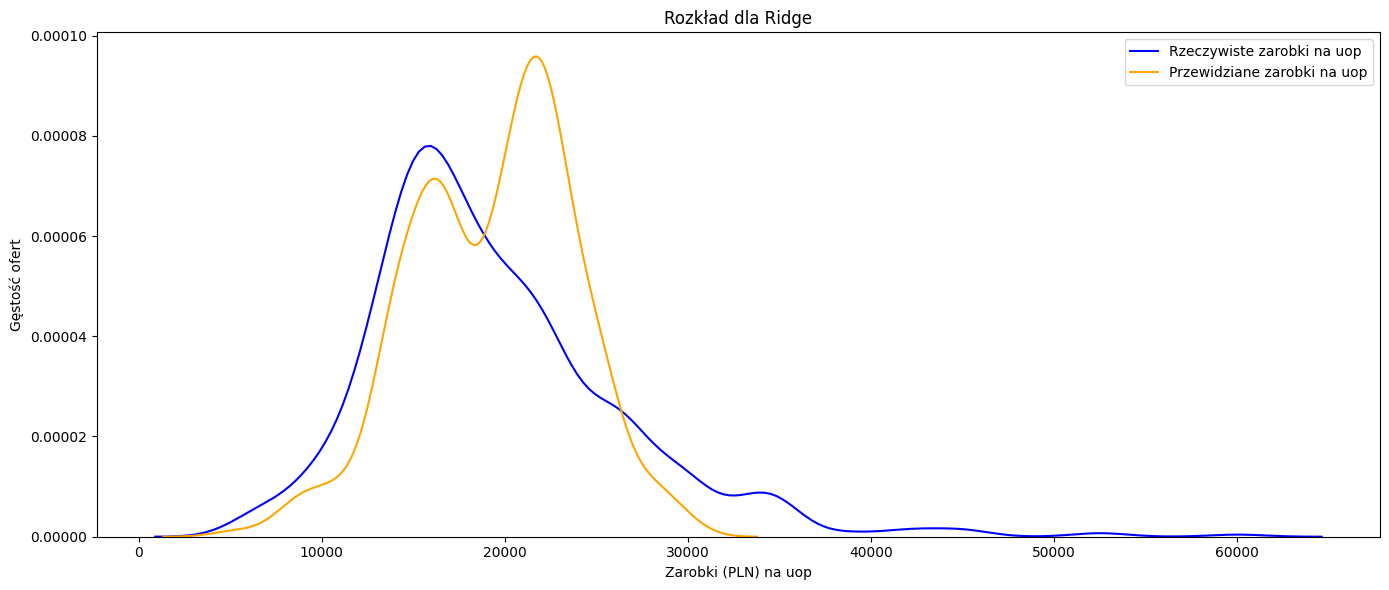

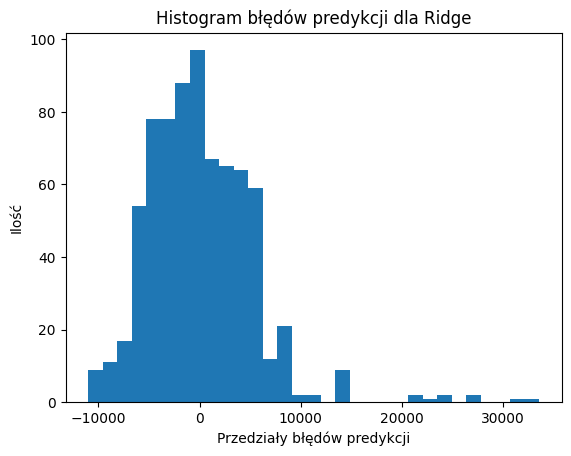

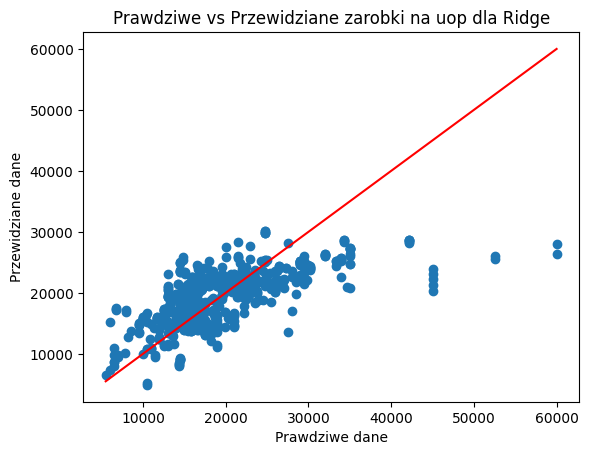

Przetwarzany model: Ridge(alpha=5)
Mean Absolute Error : 3968.53
Root Mean Squared Error : 5367.53560584371
R^2 Score : 0.44115060016797225



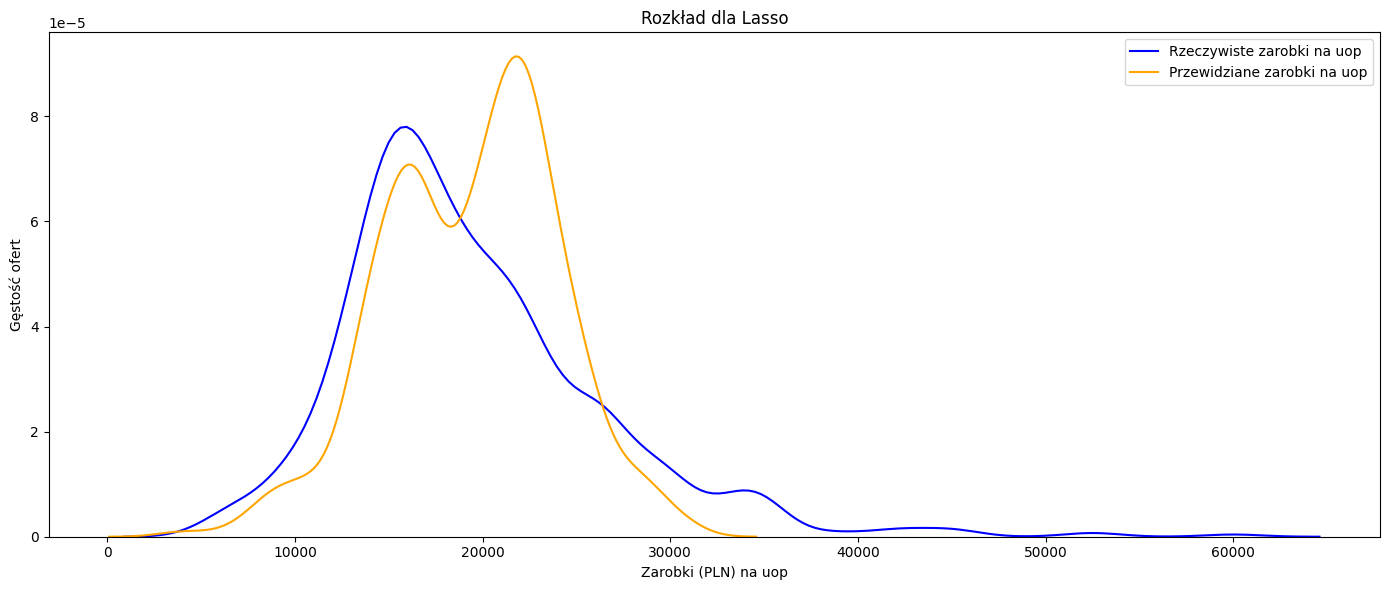

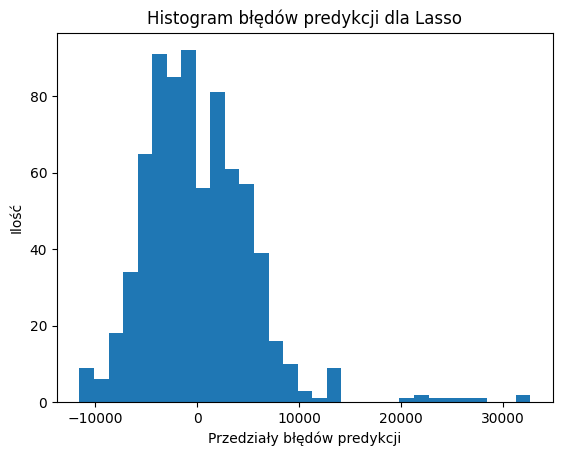

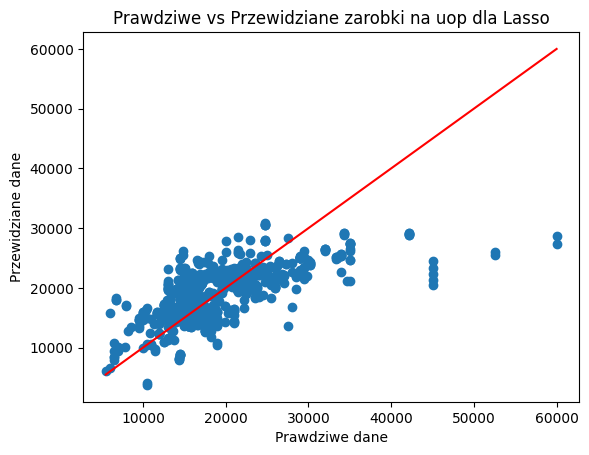

Przetwarzany model: Lasso(alpha=2)
Mean Absolute Error : 3988.48
Root Mean Squared Error : 5359.2275385544135
R^2 Score : 0.44287927625506873



In [ ]:
model = create_model_other_method(data, contract_type="uop", test_size=0.4)

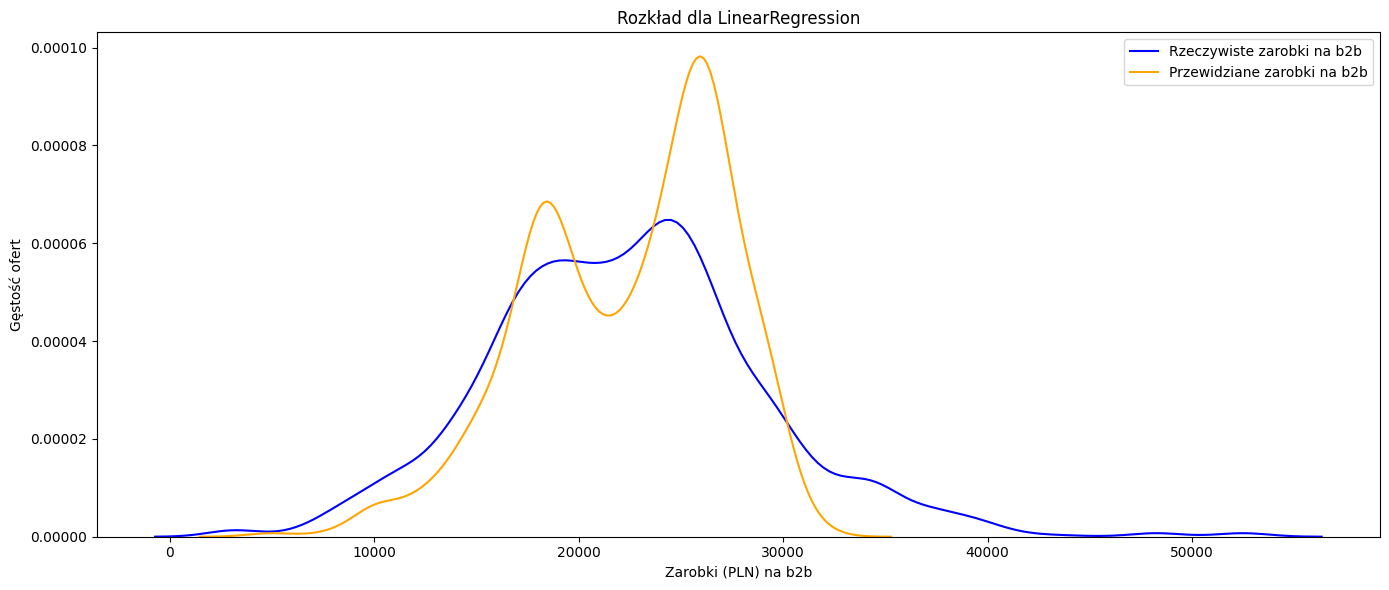

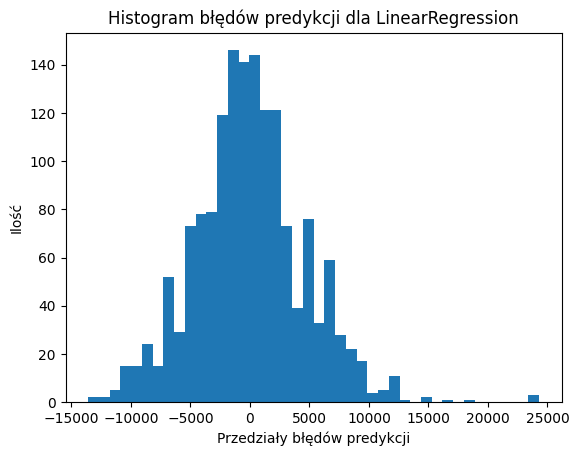

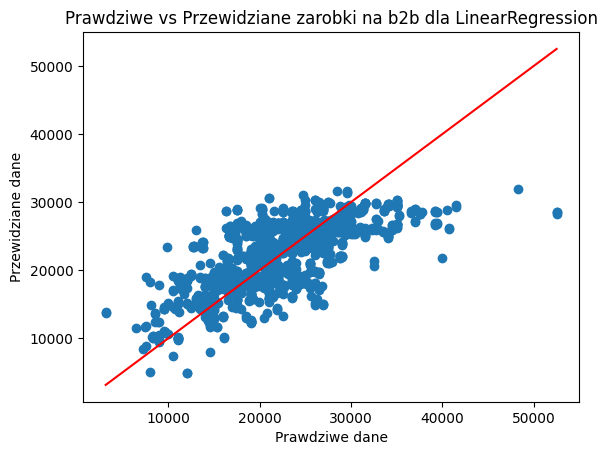

Przetwarzany model: LinearRegression()
Mean Absolute Error : 3520.18
Root Mean Squared Error : 4613.030359752686
R^2 Score : 0.48795043546964045



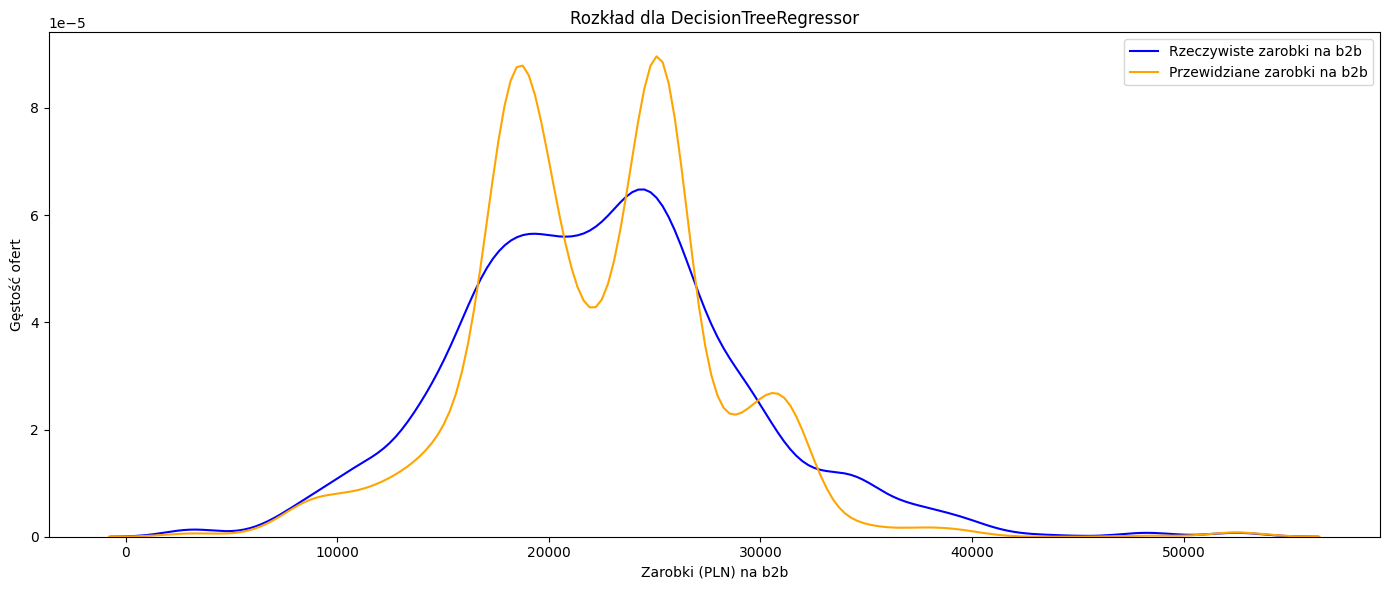

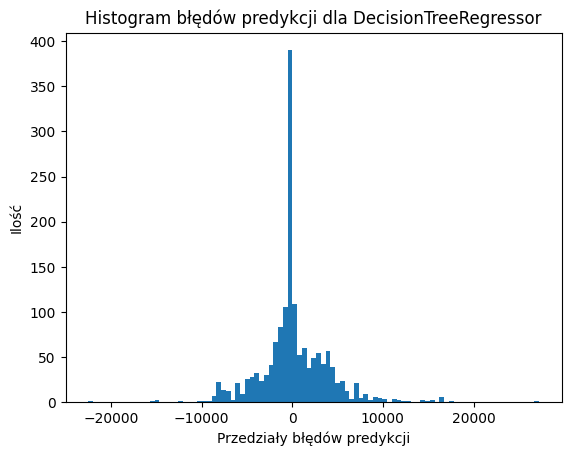

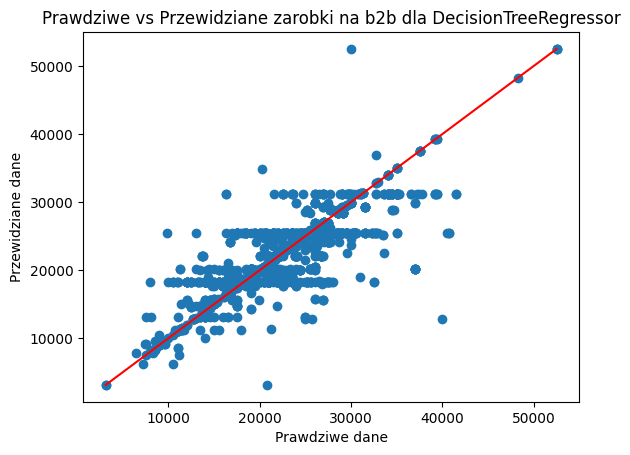

Przetwarzany model: DecisionTreeRegressor(max_depth=10, random_state=42)
Mean Absolute Error : 2441.34
Root Mean Squared Error : 3803.804216833458
R^2 Score : 0.6518425549427176



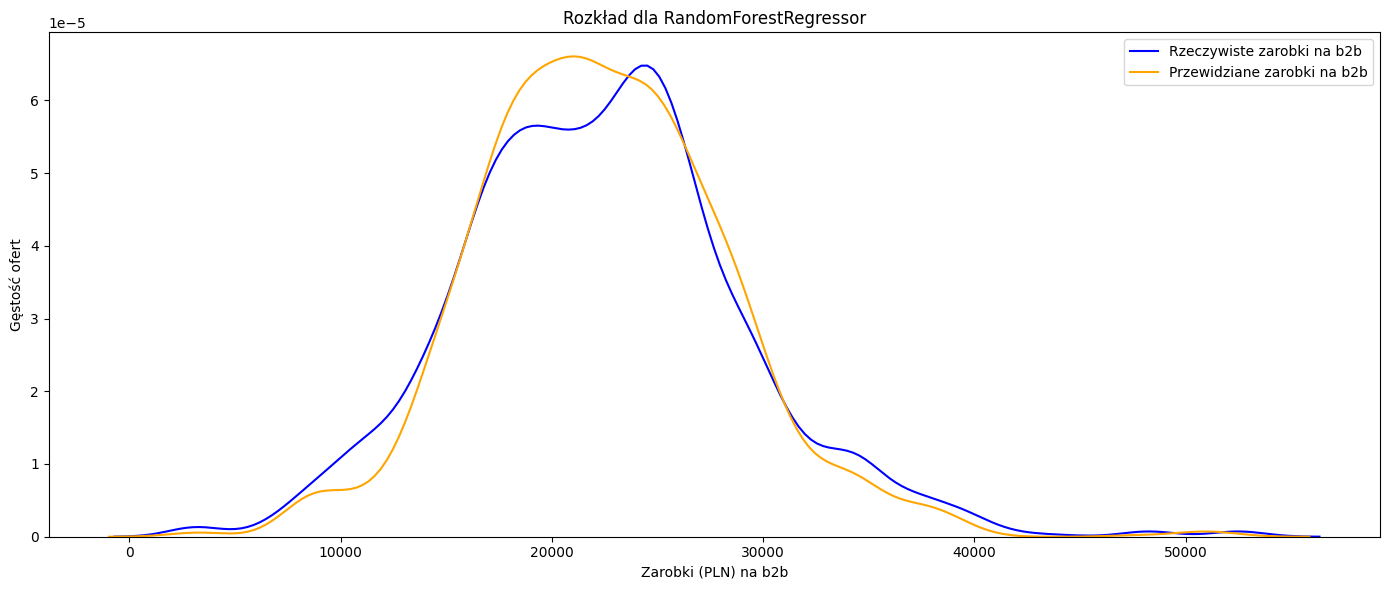

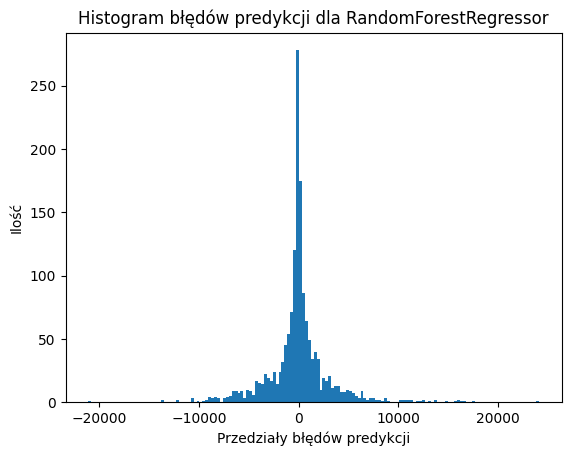

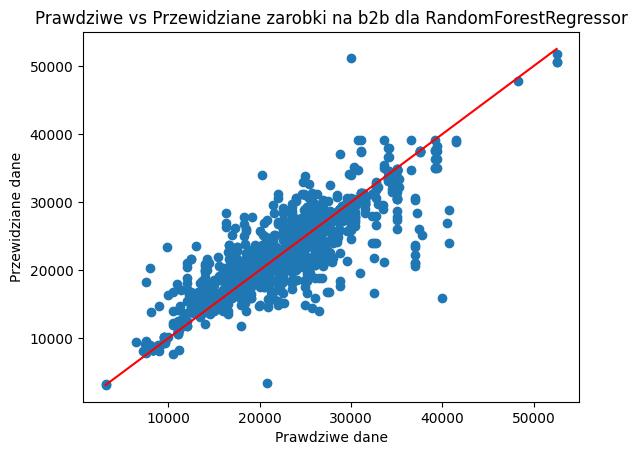

Przetwarzany model: RandomForestRegressor(n_estimators=80)
Mean Absolute Error : 1886.2
Root Mean Squared Error : 3232.3664550913777
R^2 Score : 0.7485911522637714



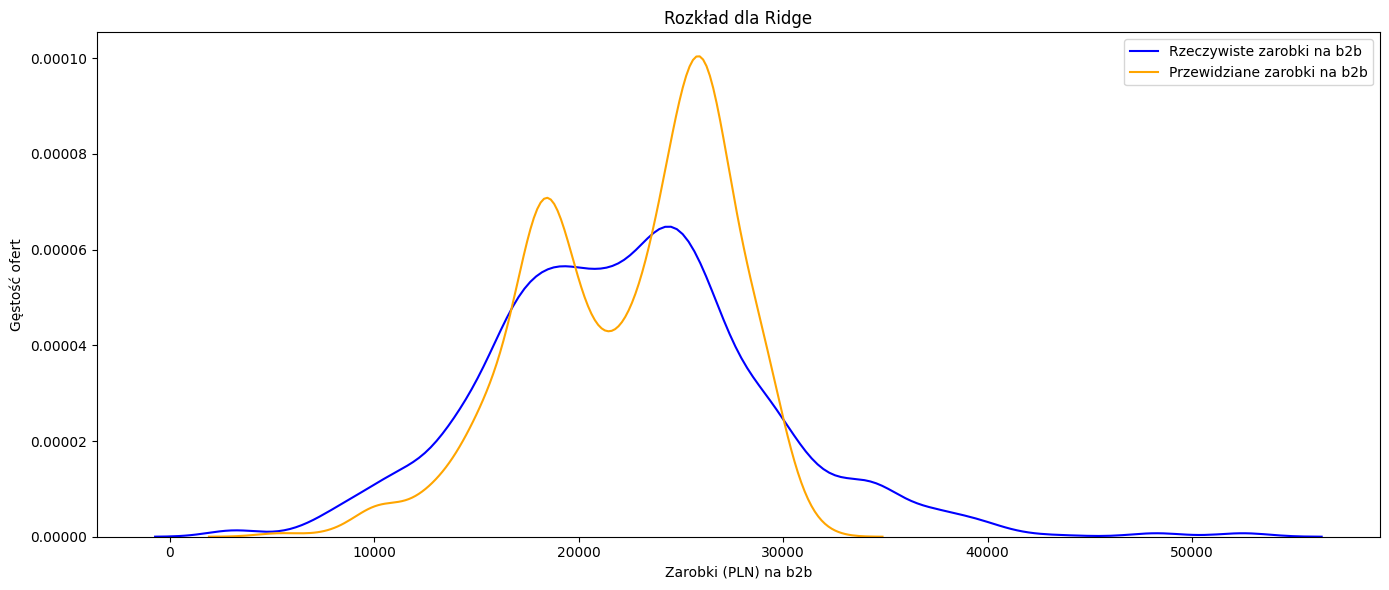

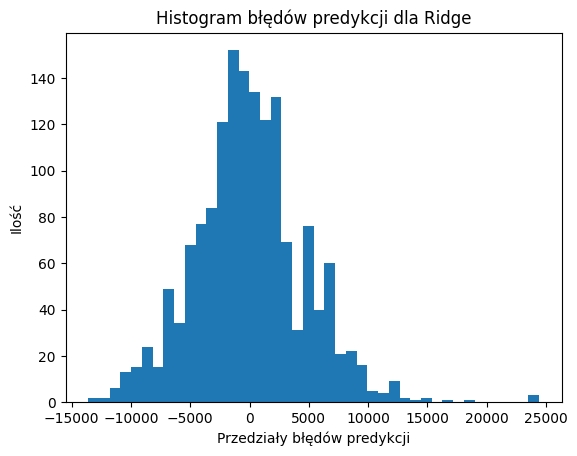

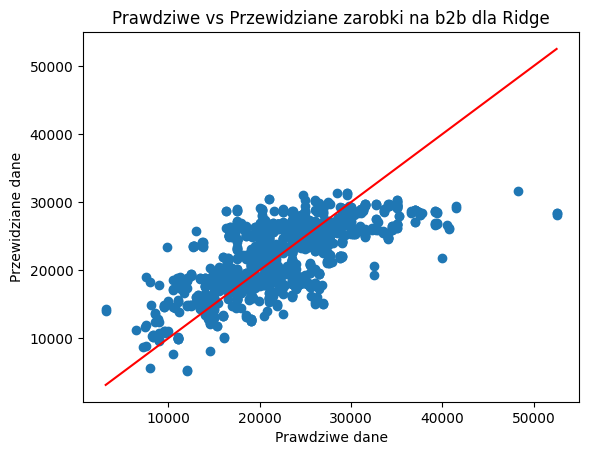

Przetwarzany model: Ridge(alpha=5)
Mean Absolute Error : 3513.59
Root Mean Squared Error : 4609.253473177625
R^2 Score : 0.4887885662718575



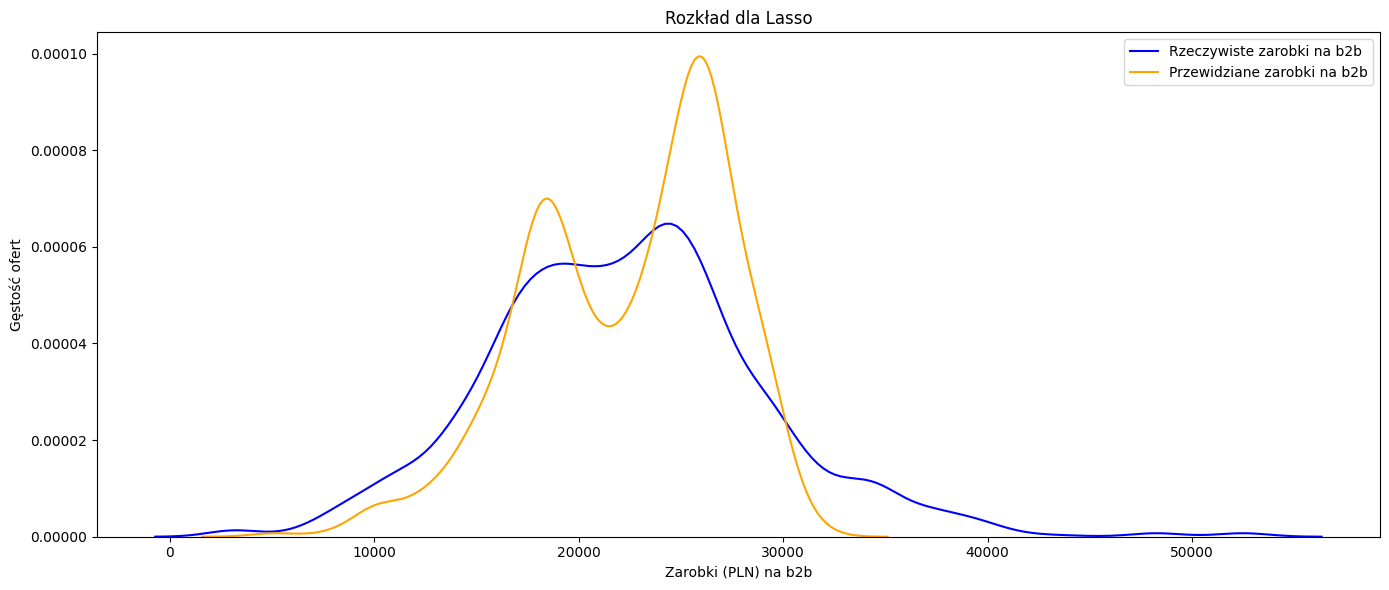

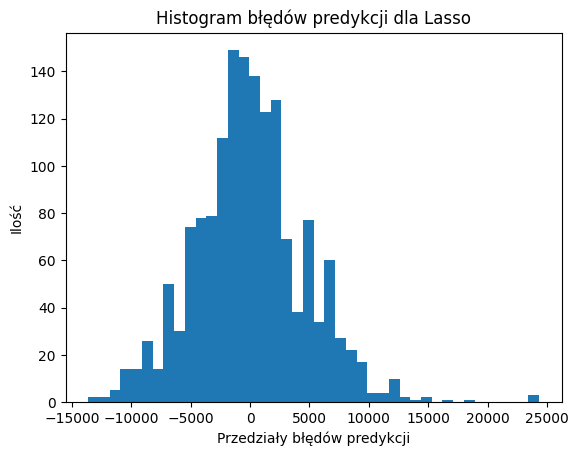

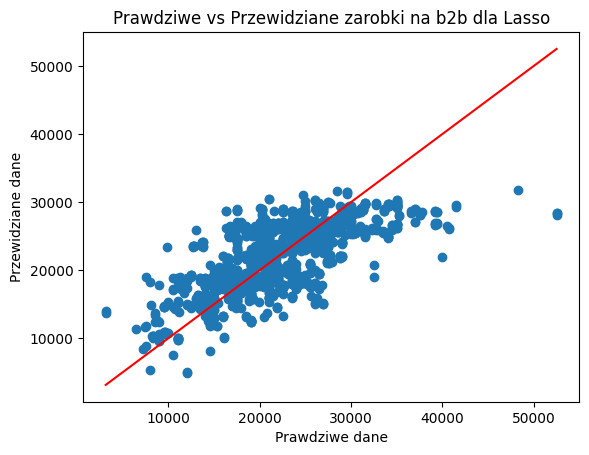

Przetwarzany model: Lasso(alpha=2)
Mean Absolute Error : 3517.98
Root Mean Squared Error : 4616.346629099682
R^2 Score : 0.487213954409519



In [ ]:
model = create_model_other_method(data, contract_type="b2b", test_size=0.4)

In [ ]:
# wstawiamy pod interesującym nas kontraktem i test sizem

test = {
    "location": "Warszawa",
    "exp": "Mid",
    "operating_mode": "Remote",
    "tech_stack": ["Docker/Kubernetes", "Python","Linux", "React", "TypeScript", "JavaScript"]
}


test_dla_qby = {
    "location": "Wrocław",
    "exp": "Junior",
    "operating_mode": "Office",
    "tech_stack": ["Python", "SQL", "C#", "Linux"]
}


test_dla_backendowca = {
    "location": "Warszawa",
    "exp": "Senior",
    "operating_mode": "Remote",
    "tech_stack": ["Go", "SQL", "Docker/Kubernetes", "AWS"]
}


# Przygotuj dane
tests = [test, test_dla_qby, test_dla_backendowca]

for t in tests:
    input_data = preprocess_input(**t)
    input_data.columns = model.feature_names_in_
    salary_pred = model.predict(input_data)
    print(f'Pensja w lokalizacji {t["location"]} dla {t["exp"]} znającego {", ".join(t['tech_stack'])}: {salary_pred.mean().round(2)} PLN Brutto')


Pensja w lokalizacji Warszawa dla Mid znającego Docker/Kubernetes, Python, Linux, React, TypeScript, JavaScript: 17697.71 PLN Brutto
Pensja w lokalizacji Wrocław dla Junior znającego Python, SQL, C#, Linux: 11521.82 PLN Brutto
Pensja w lokalizacji Warszawa dla Senior znającego Go, SQL, Docker/Kubernetes, AWS: 28787.61 PLN Brutto
